In [1]:
# Hide raw notebook code in exported HTML
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show) {
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form><input type="button" value="Return home" onclick="location.href='https://mlnoga.github.io/covid19-analysis/'"></input>
<input type="button" value="Show/hide code" onclick="code_toggle()"></input></form>

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-161715363-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-161715363-1');
</script>
''')

In [2]:
from IPython.display import Markdown as md
import time
md("# Covid-19 Data Analysis %s"%time.strftime("%B %d",time.localtime()))

# Covid-19 Data Analysis May 27

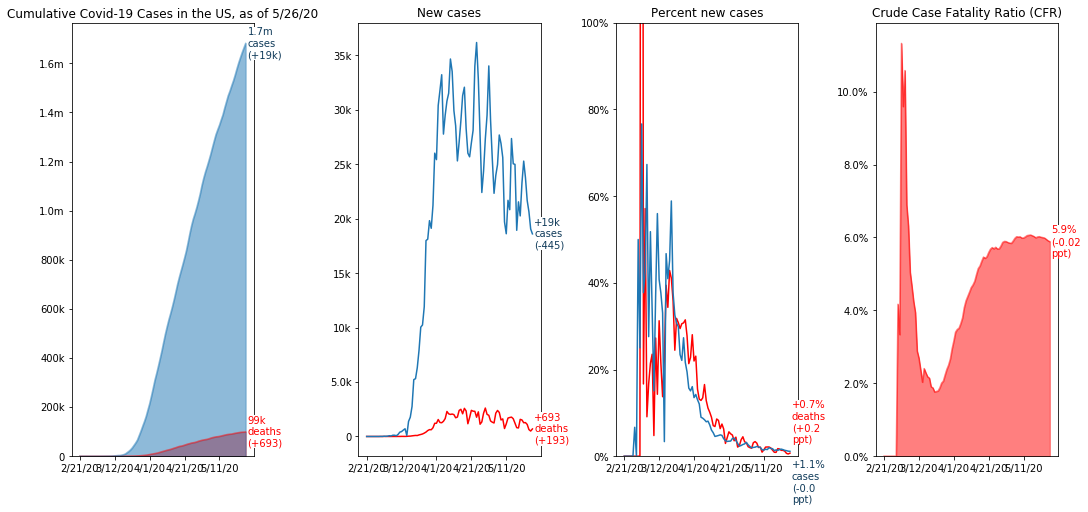

In [3]:
# Import required libraries
###########################

import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from scipy.special import expit

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

import datetime as datetime
import operator
import sys
import warnings
import math


# Data management
#################

# Load data, drop unneeded lat/long columns and group by country/region
def loadAndGroup(fileName, groupBy="Province_State", dropColumns=["UID","iso2","iso3","code3","FIPS","Admin2","Country_Region","Lat","Long_","Combined_Key"], extraDrop=[]):   #,"Population"
    df=pd.read_csv(fileName)
    for dc in dropColumns+extraDrop:
        df.drop(dc, axis=1, inplace=True)
    df=df.groupby(groupBy).sum()
    for dc in range(30):
        df.drop(df.columns[0], axis=1, inplace=True)
    return df

# Retrieve data for one country from the data frame
def getData(df, name):
    df1   =df.loc[name]
    days  =df1.index.values
    days  =[datetime.datetime.strptime(d,"%m/%d/%y").date() for d in days]
    daynr =np.array(range(len(days)))
    values=df1.to_numpy()
    return days, daynr, values

def loadAndGroupPop(fileName, groupBy="Province_State", focusColumn="Population"):
    df=pd.read_csv(fileName)
    df=df[[groupBy,focusColumn]]
    df=df.groupby(groupBy).sum()
    return df

totalLabel="US"

# Load data and calculate derived values: totals, absolute daily deltas, percentage daily deltas
useLiveGit    =True
if useLiveGit:
    confd     =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
else:
    confd     =loadAndGroup('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
confd         =confd.append(confd.sum(axis=0).rename(totalLabel))
confdDelta    =confd.diff(axis=1).replace(np.nan, 0)
confdDeltaPerc=(confdDelta/confd.shift(periods=1, axis=1)).replace(np.nan, 0).replace(np.inf, 0)
today         =confd.columns[-1]

if useLiveGit:
    deaths     =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv', extraDrop=["Population"])
else:
    deaths     =loadAndGroup('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
deaths         =deaths.append(deaths.sum(axis=0).rename(totalLabel))
deathsDelta    =deaths.diff(axis=1).replace(np.nan, 0)
deathsDeltaPerc=(deathsDelta/deaths.shift(periods=1, axis=1)).replace(np.nan, 0).replace(np.inf, 0)

crudeCFR       =deaths/confd

population=loadAndGroupPop('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
totalPopulation=population.sum(axis=0).rename(totalLabel)
population=population.append(totalPopulation)

# Calculate daily increment of a data series
def diff(ys):
    res=[0]
    cur=ys[0]
    for y in ys[1:]:
        res.append(y-cur)
        cur=y
    return res


# Formatting
############

# Format to three significant digits
def s3(x):
    return np.around(x,decimals=3)

# Human readable formatting for figures ranging in single digits, thousands, millions and billions
def humanReadable(x, plus=False):
    if math.isnan(x):
        return "NaN"
    if x<0:
        return "-"+humanReadable(-x, plus=False)
    if plus:
        return "+"+humanReadable(x, plus=False)
    if x==0:
        return "0"
    formats=[ (10000000000, 1000000000,"%.0fb"), (1000000000,1000000000, "%.1fb"), (10000000, 1000000, "%.0fm"), 
             (1000000, 1000000, "%.1fm"), (10000,1000,"%.0fk"), (1000,1000,"%.1fk"), (10,1, "%d"), (0,1, "%.1f") ]
    for threshold, divider, formatString in formats:
        if x>=threshold:
            return formatString % (x/divider)

def percentReadable(x):
    return "%.1f%%" % (x*100)
        
@plticker.FuncFormatter
def hrFormatter(x, pos):
    return humanReadable(x)

# Label last datapoint of a series
def labelLast(ax, x, y, c='tab:blue', ha='left', va='center', weight='normal', formatter=humanReadable):
    if y[-1]>0:
        ax.annotate(formatter(y[-1]), (x[-1],y[-1]), (2,0), textcoords='offset pixels', ha=ha, va=va, c=c, weight=weight, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Label maximal non-nan datapoint of a series
def labelMax(ax, x, y, c='tab:blue', ha='left', va='bottom', weight='normal', formatter=humanReadable):
    idx=np.nanargmax(y)
    ax.annotate(formatter(y[idx]), (x[idx],y[idx]), (0,5), textcoords='offset pixels', ha=ha, va=va, c=c, weight=weight, bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
        
        
# Adjust the lightness of a given color        
def adjustLightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])        


# Total overview plot
######################

# Plot overview
fig, axs=plt.subplots(figsize=[15, 7], nrows=1, ncols=4, constrained_layout=True)
colors=['r', 'tab:blue']

# Left: Cases
ax=axs[0]
globalDF=pd.DataFrame({
    'Deaths':deaths.loc[totalLabel,:], 
    'Cases':confd.loc[totalLabel,:]
})
globalDF.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Cumulative Covid-19 Cases in the US, as of %s" % today, fontsize=12)
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Label the last values
xPos=len(confd.columns)-1
x, prevX=confd.columns[-1], confd.columns[-2]
c, prevC=confd.loc[totalLabel,x], confd.loc[totalLabel,prevX]
d, prevD=deaths.loc[totalLabel,x], deaths.loc[totalLabel,prevX]
ax.text(xPos+1, d, "%s\ndeaths\n(%s)" %  (humanReadable(d), humanReadable(d-prevD, plus=True)), ha='left', va='center', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
_=ax.text(xPos+1, c, "%s\ncases\n(%s)" % (humanReadable(c), humanReadable(c-prevC, plus=True)), ha='left', va='center', c=adjustLightness(colors[1]), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


# Mid-left: Absoulte growth
ax=axs[1]
globalDFDelta=pd.DataFrame({
    'DeathsDelta':deathsDelta.loc[totalLabel,:], 
    'ConfirmedDelta':confdDelta.loc[totalLabel,:]
})
globalDFDelta.plot(ax=ax, kind='line', stacked=False, color=colors)
ax.set_title("New cases", fontsize=12)
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Label the last values
c, prevC=confdDelta.loc[totalLabel,x], confdDelta.loc[totalLabel,prevX]
d, prevD=deathsDelta.loc[totalLabel,x], deathsDelta.loc[totalLabel,prevX]
ax.text(xPos+1, d, "+%s\ndeaths\n(%s)" % (humanReadable(d), humanReadable(d-prevD, plus=True)), ha='left', va='center', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
_=ax.text(xPos+1, c, "+%s\ncases\n(%s)" % (humanReadable(c), humanReadable(c-prevC, plus=True)), ha='left', va='center', c=adjustLightness(colors[1]), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


# Mid-right: Percentage growth
ax=axs[2]
globalDFDeltaPerc=pd.DataFrame({
    'DeathsDeltaPerc':deathsDeltaPerc.loc[totalLabel,:], 
    'ConfirmedDeltaPerc':confdDeltaPerc.loc[totalLabel,:]
})
globalDFDeltaPerc.plot(ax=ax, kind='line', stacked=False, color=colors)
ax.set_title("Percent new cases", fontsize=12)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.get_legend().remove()
ax.set_ylim(0,1)

# Label the last values
c, prevC=confdDeltaPerc.loc[totalLabel,x], confdDeltaPerc.loc[totalLabel,prevX]
d, prevD=deathsDeltaPerc.loc[totalLabel,x], deathsDeltaPerc.loc[totalLabel,prevX]
ax.text(xPos+1, d+0.02, "%+.1f%%\ndeaths\n(%+.1f\nppt)" % (d*100, (d-prevD)*100), ha='left', va='bottom', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
_=ax.text(xPos+1, c-0.02, "%+.1f%%\ncases\n(%+.1f\nppt)" % (c*100, (c-prevC)*100), ha='left', va='top', c=adjustLightness(colors[1]), bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))


# Right: CFR
ax=axs[3]
globalDFCrudeCFR=pd.DataFrame({'Crude CFR':crudeCFR.loc[totalLabel,:]})
globalDFCrudeCFR.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Crude Case Fatality Ratio (CFR)", fontsize=12)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Label the last values
cfr, prevCfr=crudeCFR.loc[totalLabel,x], crudeCFR.loc[totalLabel,prevX]
ax.text(xPos+1, cfr, "%.1f%%\n(%+.2f\nppt)" % (cfr*100, (cfr-prevCfr)*100), ha='left', va='center', c=colors[0], bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

Crude CFR measures the number of cumulative deaths, divided by the cumulative number of cases. It is an admittedly problematic indicator. See the sections below for an analysis how crude CFR varies over time as an epidemic progresses. 

## State Overview


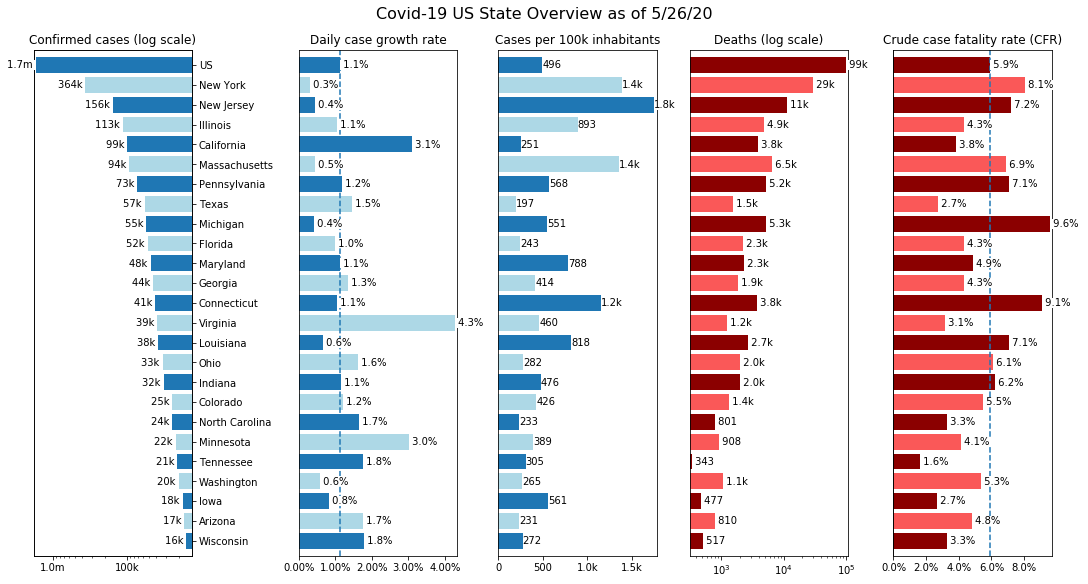

In [4]:
# State overview plot
#######################

# Calculate summary stats for all countries with number of cases above the threshold
threshold=100
validCountries=[]
for name in confd.index.values:
    confv=confd.loc[name, confd.columns[-1]]
    if confv>=threshold:
        summary={
            'Name':        name,
            'Cases':       confv,
            'CaseGrowth':  confdDeltaPerc .loc[name, confd.columns[-1]],
            'Deaths':      deaths         .loc[name, confd.columns[-1]],
            'DeathsGrowth':deathsDeltaPerc.loc[name, confd.columns[-1]],
            'CrudeCFR':    crudeCFR       .loc[name, confd.columns[-1]]
        }
        validCountries.append(summary)

# Prepare sorted stats, and limit to top countries
validCountries.sort(key=lambda x: x['Cases'], reverse=True)
validCountriesForCharts=validCountries[:25]

# Prepare data for plots
countryNames=[x['Name'] for x in validCountriesForCharts]
countryCases=[x['Cases'] for x in validCountriesForCharts]
countryGrowth=[x['CaseGrowth'] for x in validCountriesForCharts]
countryDeaths=[x['Deaths'] for x in validCountriesForCharts]
countryCrudeCFR=[x['CrudeCFR'] for x in validCountriesForCharts]
countryPop1000=[population.loc[x]['Population']/1000 for x in countryNames]
countryCasesPerPop1000=[cases/pop if pop!=0 else 0 for cases, pop in zip(countryCases, countryPop1000)]

# Prepare overview plot
fig, ax=plt.subplots(nrows=1, ncols=5, figsize=[15,8], constrained_layout=True)
fig.suptitle('Covid-19 US State Overview as of %s' % today, fontsize="16")
alternatingColorsCases=['tab:blue','lightblue']*int(len(countryNames)/2)
alternatingColorsDeaths=['darkred','#fa5858']*int(len(countryNames)/2)

# Left hand side: Plot lastest confirmed cases by country
ax[0].set_xscale('log')
ax[0].set_title('Confirmed cases (log scale)')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames, countryCases, color=alternatingColorsCases)
for i, v in enumerate(countryCases):
    ax2.text(v, i, "%s " % humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle left: Plot latest growth rate by country
ax[1].set_title('Daily case growth rate')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].margins(0.015)
ax[1].barh(countryNames, countryGrowth, color=alternatingColorsCases)
for i, v in enumerate(countryGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[1].axvline(x=countryGrowth[0], ymin=0, ymax=len(countryNames), ls="--")
    
# Middle: Plot cases per 1000 population
ax[2].set_title('Cases per 100k inhabitants')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(hrFormatter)
ax[2].margins(0.015)
countryCasesPerPop100k=np.array(countryCasesPerPop1000)*100
ax[2].barh(countryNames, countryCasesPerPop100k, color=alternatingColorsCases)
for i, v in enumerate(countryCasesPerPop100k):
    ax[2].text(v, i, hrFormatter(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle right: Plot deaths by country
ax[3].set_title('Deaths (log scale)')
ax[3].invert_yaxis()
ax[3].get_yaxis().set_visible(False)
ax[3].xaxis.set_major_formatter(hrFormatter)
ax[3].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[3].margins(0.015)
ax[3].barh(countryNames, countryDeaths, color=alternatingColorsDeaths)
ax[3].set_xscale('log')
for i, v in enumerate(countryDeaths):
    if v!=0:
        ax[3].text(v, i, " %s " % humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Right: Plot CFR by country
ax[4].set_title('Crude case fatality rate (CFR)')
ax[4].invert_yaxis()
ax[4].get_yaxis().set_visible(False)
ax[4].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[4].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[4].margins(0.015)
ax[4].barh(countryNames, countryCrudeCFR, color=alternatingColorsDeaths)
for i, v in enumerate(countryCrudeCFR):
    if v!=0:
        ax[4].text(v, i, " %.1f%% " % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[4].axvline(x=countryCrudeCFR[0], ymin=0, ymax=len(countryNames), ls="--")

plt.show()


## Time-shifted State View

These charts show the growth of confirmed cases by state. To make developments more comparable across countries, each state curve is shifted in time so that day 0 corresponds to the moment when that state exceeds a threshold number of confirmed cases (here=100). 

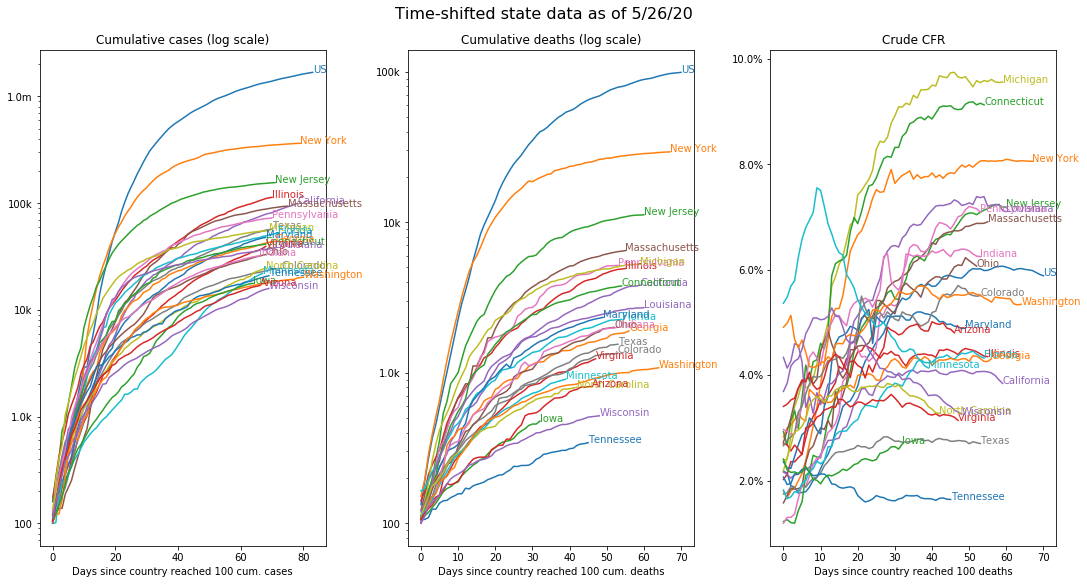

In [5]:
# Time-shifted countries plot
#############################

# Crop away starting values < n from the arrays
def startAtN(values, n):
    while(len(values)>0 and values[0]<n):
        values=values[1:]
    return values

# Plot an exponential growth line with given start value and factor
def plotFactor(ax, start,factor,length):
    xs=range(0, length)
    ys=[start]
    while(len(ys)<length):
        ys.append(factor*ys[-1])

    line, =ax.plot(xs, ys,"--k")
    c=line.get_color()
    ax.text(xs[-1], ys[-1], "%.1f%% growth" % (factor*100-100), color=c)

# Plot time-shifted data per country, setting y=0 where the country data set crosses the threshold
def plotTimeShiftedCountries(ax, df, refDf, validCountries, threshold, yscale, label, xlabel, ylabel, yformatter):
    ax.set_title(label, fontsize=12)
    ax.set_xlabel(xlabel)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.yaxis.set_major_formatter(yformatter)

    # Plot individual country curves
    maxLen=0
    for i, cty in enumerate(validCountries, start=0):
        name=cty['Name']
        days, daynr, values=getData(df, name)
        if (refDf is None):
            shiftedValues=startAtN(values, threshold)
        else:
            refDays, refDaynr, refValues=getData(refDf, name)
            shiftedRefValues=startAtN(refValues, threshold)
            shiftedValues=values[-len(shiftedRefValues):] if len(shiftedRefValues)>0 else []
        if(len(shiftedValues)>0):
            if(len(shiftedValues)>maxLen):
                maxLen=len(shiftedValues)
            line, =ax.plot(range(0, len(shiftedValues)), shiftedValues)
            c=line.get_color()
            ax.text(len(shiftedValues)-1, shiftedValues[-1], name, color=c)
    

threshold=100
fig, ax=plt.subplots(nrows=1, ncols=3, figsize=[15,8], constrained_layout=True)
fig.suptitle('Time-shifted state data as of %s' % today, fontsize="16")

plotTimeShiftedCountries(ax[0], confd, None, validCountriesForCharts, threshold, 'log', 
                         "Cumulative cases (log scale)",
                         "Days since country reached %s cum. cases" % humanReadable(threshold),
                         None, hrFormatter)

plotTimeShiftedCountries(ax[1], deaths, None, validCountriesForCharts, threshold, 'log', 
                         "Cumulative deaths (log scale)",
                         "Days since country reached %s cum. deaths" % humanReadable(threshold),
                         None, hrFormatter)

plotTimeShiftedCountries(ax[2], deaths/confd, deaths, validCountriesForCharts, threshold, 'linear', 
                         "Crude CFR",
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         None, plticker.PercentFormatter(1.0))

plt.show()

## State Projections Overview


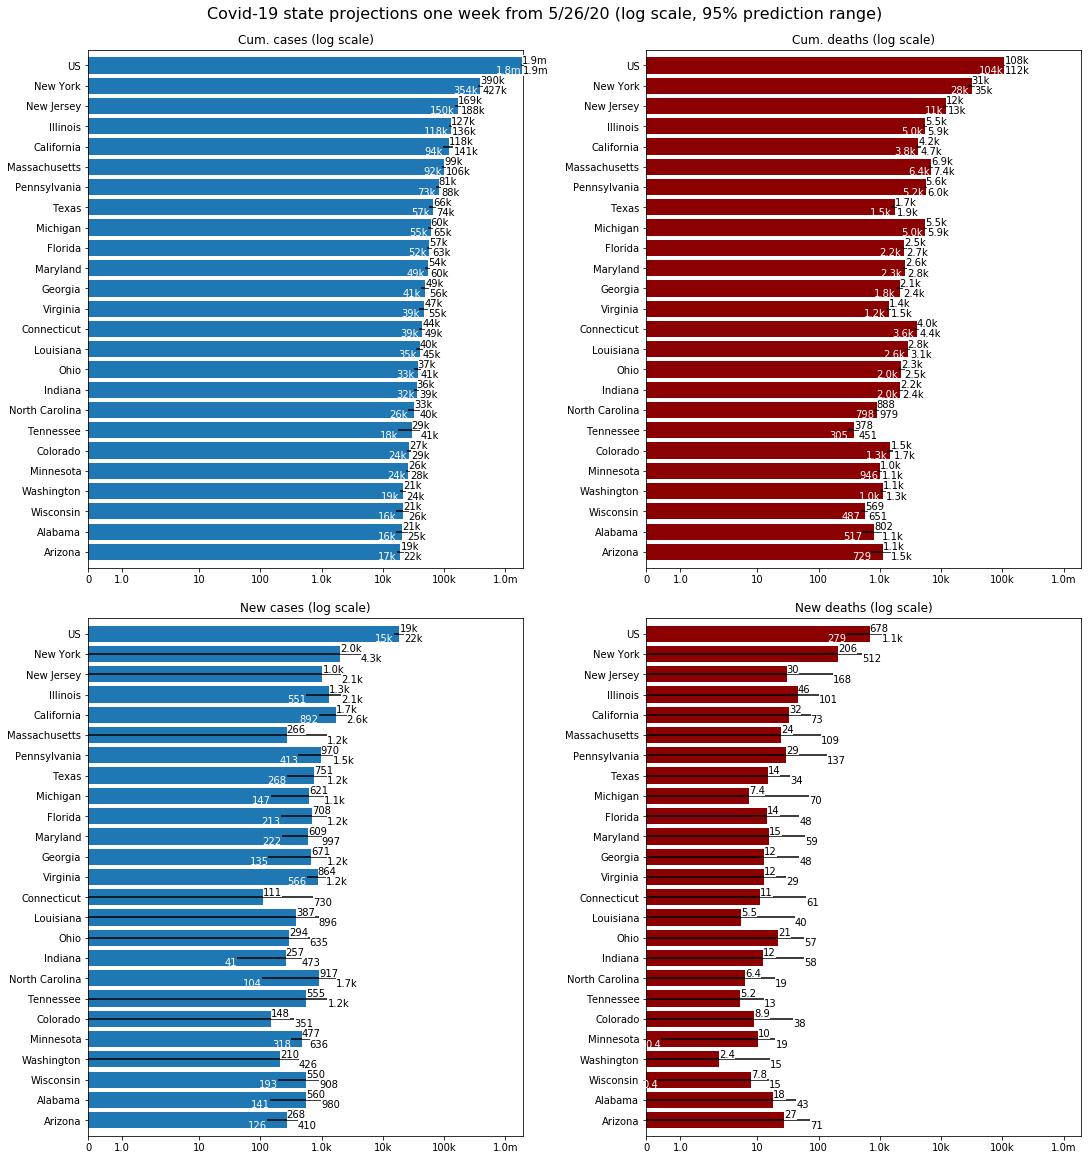

In [6]:
# Function families to apply in curve fitting
#############################################

# Exponential fit function
def fitExp(x, a, b):
    return a * np.exp(b*x)

# Generate a label for the exponential model
def fitExpLabeller(popt):
    return "f(t)=%ge^(%gt)" % (s3(popt[0]), s3(popt[1]))


# Derivative of the exponential fit function
def fitExpDerivative(x, a, b):
    return a * b * np.exp(b*x)

# Generate a label for the derivative of the exponential model
def fitExpDerivativeLabeller(popt):
    return "f(t)=%ge^(%gt)" % (s3(popt[0]*popt[1]), s3(popt[1]))


# Sigmoid model for fitting
def fitSig(t, a, b, c):
    return a/(1.0+np.exp(-b*t - c)) 

# Generate a label for the sigmoid model
def fitSigLabeller(popt):
    return "f(t)=%g \u03c3(%gt%+g)" % (s3(popt[0]), s3(popt[1]), s3(popt[2]))


# Derivative of the sigmoid fit function
def fitSigDerivative(t, a, b, c):
    s=fitSig(t,1,b,c)
    return a*b*s*(1-s)

# Generate a label for the derivative of the sigmoid model
def fitSigDerivativeLabeller(popt):
    return "f(t)=%g \u03c3'(%gt%+g)" % (s3(popt[0]*popt[1]), s3(popt[1]), s3(popt[2]) )


# Extended sigmoid fit function, with continued linear growth
def fitSigExt(t, a, b, c, n):
    return fitSig(t,a,b,c) + n*np.log(1+np.exp(b*t+c))

# Generate a label for the extended sigmoid fit model
def fitSigExtLabeller(popt):
    return "f(t)=%g \u03c3'(%gt%+g)\n%+g log(1+e^(%gt%+g))" % (s3(popt[0]), s3(-popt[1]), s3(-popt[2]), s3(popt[3]), s3(-popt[1]), s3(-popt[2]))

    
# Derivative of the extended sigmoid fit function, with continued flat tail
def fitSigExtDerivative(t, a, b, c, n):
    s=fitSig(t,1,b,c)
    return a*b*s*(1-s) + fitSig(t, n*b, b,c)

# Generate a label for the derivative of the extended sigmoid model
def fitSigExtDerivativeLabeller(popt):
    return "f(t)=%g \u03c3'(%gt%+g)\n%+g \u03c3(same)" % (s3(popt[0]*popt[1]), s3(-popt[1]), s3(-popt[2]), s3(popt[3]), )


# Curve fitting helpers
#######################

# For a given curve fit, calculate the conf% confidence and prediction bands.
# Confidence is for the true value. Prediction is for future measured values, including noise
# Inspired by https://stats.stackexchange.com/questions/15423/how-to-compute-prediction-bands-for-non-linear-regression
def calculateConfidenceAndPredictionBands(pxs, xs, ys, f, popt, pcov, conf=0.95):
    sumOfSquares=sum((ys-f(xs,*popt))**2)
    degreesOfFreedom=len(xs)-len(popt)
    alpha=1.0-conf
    criticalT = stats.t.ppf(1.0 - alpha / 2.0, degreesOfFreedom)

    pys=f(pxs, *popt)
    lpb, lcb, ucb, upb=[], [], [], []
    
    # Debugging: plot chart
    #fig, ax=plt.subplots(figsize=[15, 4], nrows=1, ncols=1)
    #ax.plot(xs, ys, color="k", ls=" ", marker='o', label='Data')
    #ax.plot(pxs, pys, color="tab:blue", label="Fit")
    #ax.set_yscale('log')
    #plt.show()
    
    #print("Start fitting with criticalT=%g and dof=%g" % (criticalT, degreesOfFreedom))
    
    # for all predicted points
    grad=np.array([0]*len(popt))
    ptmp=popt.copy()
    epsilon=1e-8
    confidences=[]
    predictions=[]
    for px, py in zip(pxs, pys):
       
        # calculate gradient for all parameter dimensions at this point
        for i in range(len(popt)):
            # Calculate numerical derivative of the best fit function w.r.t. parameter i
            epsilon=1e-4
            ptmp[i]=popt[i]-epsilon
            yl=f(px, *ptmp)
            ptmp[i]=popt[i]+epsilon
            yh=f(px, *ptmp)
            ptmp[i]=popt[i]
            grad[i]=(yh-yl)/(2.0*epsilon)
        
        # calculate variance of the best fit function based on the gradient and the covariance
        c=grad.dot(pcov.dot(grad.T))
        
        # compute confidence and prediction intervals at this point
        if c<0: # avoid numerical stability issues
            c=-c
        confidence=criticalT*math.sqrt(c)
        prediction=criticalT*math.sqrt(c+sumOfSquares/degreesOfFreedom)
        confidences.append(confidence)
        predictions.append(prediction)
        
        lpb.append(py-prediction)
        lcb.append(py-confidence)
        ucb.append(py+confidence)
        upb.append(py+prediction)

    return lpb, lcb, pys, ucb, upb


# Fit state curves and generate summaries
###########################################

# Silently ignore optimize warnings when curve fitting
warnings.simplefilter("ignore", OptimizeWarning)
warnings.simplefilter("ignore", RuntimeWarning)
np.seterr(over='ignore')

validCountries=list(filter(lambda c: c["Name"]!="Grand Princess", validCountries)) # FIX 

# Prepare x axis and results for projections
extDayCount=7
px       = np.linspace(0, len(confd.columns)-1+extDayCount, 3*(len(confd.columns)+extDayCount)) # resample to make curves smoother
firstDay=datetime.datetime.strptime(confd.columns[0],"%m/%d/%y").date()
pxlabels = [datetime.datetime.combine(firstDay,datetime.time(0,0,0))+datetime.timedelta(days=(d)) for d in px]

tmp=np.zeros((len(validCountries), len(px)))
newCasesFits, newCasesLpb, newCasesLcb, newCasesNom, newCasesUcb, newCasesUpb={}, tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy()
cumCasesFits, cumCasesLpb, cumCasesLcb, cumCasesNom, cumCasesUcb, cumCasesUpb={}, tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy()
newDeathsFits, newDeathsLpb, newDeathsLcb, newDeathsNom, newDeathsUcb, newDeathsUpb={}, tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy()
cumDeathsFits, cumDeathsLpb, cumDeathsLcb, cumDeathsNom, cumDeathsUcb, cumDeathsUpb={}, tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy(), tmp.copy()
tmp=None

# For all states
for ci, cty in enumerate(validCountries): #enumerate([{'Name':'Germany'}]): 
    countryName=cty['Name']
    
    # For both series of data, cases and deaths
    seriesSets=[(confd, "Cases"), 
                (deaths, "Deaths")]
    for df, seriesName in seriesSets:
        xlabels, x, y=getData(df, countryName)
        yd= diff(y)
        n = len(yd)

        if seriesName=="Deaths" and y[-1]<threshold/2:  # Skip fits with insufficient data
            continue

        # For all fitting functions, exponential, sigmoid etc., find best fit
        fitSets=[(0, fitExpDerivative, fitExpDerivativeLabeller, [10, 0.2],  fitExp, fitExpLabeller ), 
                 (1, fitSigDerivative, fitSigDerivativeLabeller, [max(yd)*3/2, 0.2, -10],  fitSig, fitSigLabeller),
                 (2, fitSigExtDerivative, fitSigExtDerivativeLabeller, [max(yd)*3/2, 0.2, -10, 100], fitSigExt, fitSigExtLabeller)]
        bestSeor, bestIndex, bestPopt, bestPcov=sys.float_info.max, None, [], []
        sndbestSeor, sndbestIndex, sndbestPopt, sndbestPcov=sys.float_info.max, None, [], []
        for index, f, fLabeller, p0, fInt, fIntLabeller in fitSets:
            try:
                # alpha=0.05
                try:
                    # Standard error function first; gives best fit for last 2-3 weeks, 
                    # although fits for the early days are poorer
                    popt, pcov = curve_fit(f, x, yd, p0)
                except (RuntimeError, OverflowError, TypeError) as e:
                    # Modified poisson error with x^4. Deal with outliers for the last few
                    # days, which cause the fitting to fail with the standard error function.
                    popt, pcov = popt, pcov = curve_fit(f, x, yd, p0, sigma=[math.pow(max(theY,1.0), 1/4.0) for theY in yd], absolute_sigma=True)
 
                # Small constant relative error: alpha*x. Performs worse for last 20 days
                #popt, pcov = curve_fit(f, x, yd, p0, sigma=[alpha*theY+1 for theY in yd], absolute_sigma=True)
                # Possion error: sqrt(y), inherent for all rate counting applications. Performs worse for last 20 days
                #popt, pcov = curve_fit(f, x, yd, p0, sigma=[math.sqrt(theY+1) for theY in yd], absolute_sigma=True)
                # Combined constant relative and poisson. Performs worse for last 20 days
                #popt, pcov = curve_fit(f, x, yd, p0, sigma=[math.sqrt(theY+alpha*alpha*theY*theY+1) for theY in yd], absolute_sigma=True)
                    
                #r2         = 1.0-(sum((yd-f(x,*(popt)))**2)/((n-1.0)*np.var(yd,ddof=1)))
                # pseudo-R2 for nonlinear fits, from https://stackoverflow.com/a/14530853
                # Better use standard error of the estimate for a non-linear fit. Lower values are better
                seor=math.sqrt(sum((yd-f(x, *(popt)))**2)/(n-len(popt)))
                
                if abs(popt[1]>1): # PRIOR: we know the exponent is fairly small, use this to ignore absurd fits
                    continue
                if abs(popt[1]<=0): # PRIOR: we know the exponent has to be positive
                    continue
                if len(popt)==4 and (popt[3]>popt[0]):# PRIOR: we know the plateau should be smaller than the peak, ignore absurd fits
                    continue
                if len(popt)==4 and (popt[3]<0):      # PRIOR: we know the plateau should be larger than zero
                    index, f, fLabeller, popt=1, fitSigDerivative, fitSigDerivativeLabeller, popt[:-1]
                    pcov=np.array([pcov[0][:-1], pcov[1][:-1], pcov[2][:-1] ])
                if f(px[-1], *popt)>math.pow(10, extDayCount/7)*y[-1]: # PRIOR: ignore absurdly high predictions
                    continue
                    
                # make this the new best result, if it exceeds the previous one by a threshold
                # added cache in case an intermediate result was somewhat better, but the new one isn't much better
                gamma=1.1
                if seor*gamma<bestSeor and seor*gamma<sndbestSeor:
                    bestSeor, bestIndex, bestPopt, bestPcov=seor, index, popt, pcov
                    sndbestSeor=sys.float_info.max
                elif seor*gamma<bestSeor:
                    if sndbestSeor<sys.float_info.max:
                        bestSeor, bestIndex, bestPopt, bestPcov=sndbestSeor, sndbestIndex, sndbestPopt, sndbestPcov
                    sndbestSeor, sndbestIndex, sndbestPopt, sndbestPcov=seor, index, popt, pcov
                
            except (RuntimeError, OverflowError, TypeError) as e:
                continue

        seor, popt, pcov=bestSeor, bestPopt, bestPcov
        if bestIndex!=None:
            index, f, fLabeller, p0, fInt, fIntLabeller=fitSets[bestIndex]
        else:
            index, f, fLabeller, p0, fInt, fIntLabeller=0, None, None, [], None, None

        # For both new and cumulative variants of each series
        newOrCumSets=[(yd, f,    fLabeller,    "New"), 
                      (y,  fInt, fIntLabeller, "Cum.")]
        for ys, f, fLabeller, newOrCum in newOrCumSets:
            # Fit data
            try:
                if newOrCum=='Cum.': # Recalculate R2 as the stored R2 was for new cases, not cumulative
                    # r2 = 1.0-(sum((ys-f(x,*(popt)))**2)/((n-1.0)*np.var(ys,ddof=1)))
                    # pseudo-R2 for nonlinear fits, from https://stackoverflow.com/a/14530853
                    # Better use standard error of the estimate for a non-linear fit. Lower values are better
                    seor=math.sqrt(sum((ys-f(x, *(popt)))**2)/(n-len(popt)))
                lpb, lcb, nom, ucb, upb=calculateConfidenceAndPredictionBands(px, x, ys, f, popt, pcov)
            except (RuntimeError, OverflowError, TypeError) as e:
                lpb, lcb, nom, ucb, upb=[math.nan], [math.nan], [math.nan], [math.nan], [math.nan], 

            # Store stats
            if seriesName=="Cases":
                if newOrCum=="New":
                    newCasesFits[countryName]=(f, fLabeller, popt, pcov, seor)
                    newCasesLpb[ci], newCasesLcb[ci], newCasesNom[ci], newCasesUcb[ci], newCasesUpb[ci]=lpb, lcb, nom, ucb, upb
                else:
                    cumCasesFits[countryName]=(f, fLabeller, popt, pcov, seor)
                    cumCasesLpb[ci], cumCasesLcb[ci], cumCasesNom[ci], cumCasesUcb[ci], cumCasesUpb[ci]=lpb, lcb, nom, ucb, upb
            else:
                if newOrCum=="New":
                    newDeathsFits[countryName]=(f, fLabeller, popt, pcov, seor)
                    newDeathsLpb[ci], newDeathsLcb[ci], newDeathsNom[ci], newDeathsUcb[ci], newDeathsUpb[ci]=lpb, lcb, nom, ucb, upb
                else:
                    cumDeathsFits[countryName]=(f, fLabeller, popt, pcov, seor)
                    cumDeathsLpb[ci], cumDeathsLcb[ci], cumDeathsNom[ci], cumDeathsUcb[ci], cumDeathsUpb[ci]=lpb, lcb, nom, ucb, upb


# Convert projection arrays to data frames, resorted in descending order of cumulative cases and reprojecting total bottom-up
def prepareDF(arr, idx, cols, reidx=None, nom=None, sign=1):
    df=pd.DataFrame(arr, idx,cols)
    if reidx is None:
        df=df.sort_values(by=[cols[-1]], ascending=False)
    else:
        df=df.reindex(reidx)
        
    if nom is None:
        df.loc[totalLabel]=df.iloc[1:, :].sum(skipna=True)
    else:
        delta=df.iloc[1:, :] - nom.iloc[1:, :]
        deltaSq=delta.pow(2.0)
        total=deltaSq.sum(skipna=True)
        totalSqrt=total.pow(0.5)*sign
        df.loc[totalLabel]=nom.loc[totalLabel]+totalSqrt
    return df

# Convert projection arrays to data frames, resorted in descending order of cumulative cases
validCountryNames=[x['Name'] for x in validCountries]
cumCasesNomDF=prepareDF(cumCasesNom, validCountryNames, pxlabels)
cumCasesLpbDF=prepareDF(cumCasesLpb, validCountryNames, pxlabels, cumCasesNomDF.index, cumCasesNomDF, -1)
cumCasesLcbDF=prepareDF(cumCasesLcb, validCountryNames, pxlabels, cumCasesNomDF.index, cumCasesNomDF, -1)
cumCasesUcbDF=prepareDF(cumCasesUcb, validCountryNames, pxlabels, cumCasesNomDF.index, cumCasesNomDF,  1)
cumCasesUpbDF=prepareDF(cumCasesUpb, validCountryNames, pxlabels, cumCasesNomDF.index, cumCasesNomDF,  1)

newCasesNomDF=prepareDF(newCasesNom, validCountryNames, pxlabels, cumCasesNomDF.index)
newCasesLpbDF=prepareDF(newCasesLpb, validCountryNames, pxlabels, cumCasesNomDF.index, newCasesNomDF, -1)
newCasesLcbDF=prepareDF(newCasesLcb, validCountryNames, pxlabels, cumCasesNomDF.index, newCasesNomDF, -1)
newCasesUcbDF=prepareDF(newCasesUcb, validCountryNames, pxlabels, cumCasesNomDF.index, newCasesNomDF,  1)
newCasesUpbDF=prepareDF(newCasesUpb, validCountryNames, pxlabels, cumCasesNomDF.index, newCasesNomDF,  1)

newDeathsNomDF=prepareDF(newDeathsNom, validCountryNames, pxlabels, cumCasesNomDF.index)
newDeathsLpbDF=prepareDF(newDeathsLpb, validCountryNames, pxlabels, cumCasesNomDF.index, newDeathsNomDF, -1)
newDeathsLcbDF=prepareDF(newDeathsLcb, validCountryNames, pxlabels, cumCasesNomDF.index, newDeathsNomDF, -1)
newDeathsUcbDF=prepareDF(newDeathsUcb, validCountryNames, pxlabels, cumCasesNomDF.index, newDeathsNomDF,  1)
newDeathsUpbDF=prepareDF(newDeathsUpb, validCountryNames, pxlabels, cumCasesNomDF.index, newDeathsNomDF,  1)

cumDeathsNomDF=prepareDF(cumDeathsNom, validCountryNames, pxlabels, cumCasesNomDF.index)
cumDeathsLpbDF=prepareDF(cumDeathsLpb, validCountryNames, pxlabels, cumCasesNomDF.index, cumDeathsNomDF, -1)
cumDeathsLcbDF=prepareDF(cumDeathsLcb, validCountryNames, pxlabels, cumCasesNomDF.index, cumDeathsNomDF, -1)
cumDeathsUcbDF=prepareDF(cumDeathsUcb, validCountryNames, pxlabels, cumCasesNomDF.index, cumDeathsNomDF,  1)
cumDeathsUpbDF=prepareDF(cumDeathsUpb, validCountryNames, pxlabels, cumCasesNomDF.index, cumDeathsNomDF,  1)


# Plot overview of state projections
######################################

fig, axs=plt.subplots(nrows=2, ncols=2, figsize=[15,16], constrained_layout=True)
fig.suptitle('Covid-19 state projections one week from %s (log scale, 95%% prediction range)' % today, fontsize="16")

low=0
high=max(cumCasesUpbDF.iloc[:,-1])
topK=len(validCountriesForCharts)

plotParams=[(axs[0][0], "Cum. cases (log scale)",  cumCasesNomDF.iloc[:topK,-1], cumCasesLpbDF.iloc[:topK,-1],  cumCasesUpbDF.iloc[:topK, -1],  "tab:blue", "w"),
            (axs[0][1], "Cum. deaths (log scale)", cumDeathsNomDF.iloc[:topK,-1], cumDeathsLpbDF.iloc[:topK,-1], cumDeathsUpbDF.iloc[:topK,-1], "darkred",  "w"),
            (axs[1][0], "New cases (log scale)",   newCasesNomDF.iloc[:topK,-1],  newCasesLpbDF.iloc[:topK,-1],  newCasesUpbDF.iloc[:topK,-1],  "tab:blue", "w"),
            (axs[1][1], "New deaths (log scale)",  newDeathsNomDF.iloc[:topK,-1], newDeathsLpbDF.iloc[:topK,-1], newDeathsUpbDF.iloc[:topK,-1], "darkred",  "w"), ] 

for ax, title, proj, errLow, errHigh, barColor, fontColor in plotParams:
    ax.set_title(title)
    ax.set_xscale('symlog')
    ax.xaxis.set_major_formatter(hrFormatter)
    ax.invert_yaxis()
    ax.set_xlim(low, high)
    ax.margins(0.015)
    ax.barh(proj.index, proj, color=barColor, 
               xerr=(np.array(proj)-np.array(errLow), np.array(errHigh)-np.array(proj)) )
    
    for j, v in enumerate(errLow):
        if v>low:
            ax.text(v, j+0.25, humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'), color=fontColor)
    for j, v in enumerate(errHigh):
        if v>low:
            ax.text(v, j+0.25, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

    # then label midpoint value
    for j, v in enumerate(proj):
        if v>low:
            ax.text(v, j-0.25, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

plt.show()



State projections are based on fitting curves to the daily changes in cases and deaths. This removes a challenge with cumulative data: each cumulative data point is correlated with all previous data points. So fitting on the daily changes should result in better accuracy. These fits are transferred to the cumulative values by symbolic integration. 

To project current trends, we try and fit three families of curves: the derivative of an exponential, which is itself exponential; the derivative of a sigmoid, and the derivative of a sigmoid plus a sigmoid to simulate constant terminal growth. We select the value with the lowest squared error. Such projections should be taken with a grain of salt, as both types of functions grow and diverge rapidly. The global projection is the sum of all country projections, including countries not shown here.

The overview chart now shows 95% prediction ranges for the values. That is, 95% of future values on the given date, including measurement noise, should fall within the given error bound. These bounds have tightened as we now use the full covariance matrix, including correlations between different parameters. Confidence ranges for the underlying future value, i.e. without noise, are even tighter. Those are shown on the country details charts.

# State Projection Details

State projections are based on fitting curves to the daily changes in cases and deaths. Charts show both the 95% confidence intervals in blue shading, and 95% prediction intervals in blue dashes. The confidence interval means that the true value, without measurement noise, lies in that range. The prediction intervals mean that future data point measurements, including noise, will lie in that range. Newly added in orange is a projection of crude CFR based on cumulated fatality and cumulated case projections. 

Note that passing the peak of new infections does not indicate the peak strain on healthcare systems is already behind us; also note this does not imply that social distancing can be relaxed. Without a reduction in physical contacts, the curves would soon resume exponential growth.

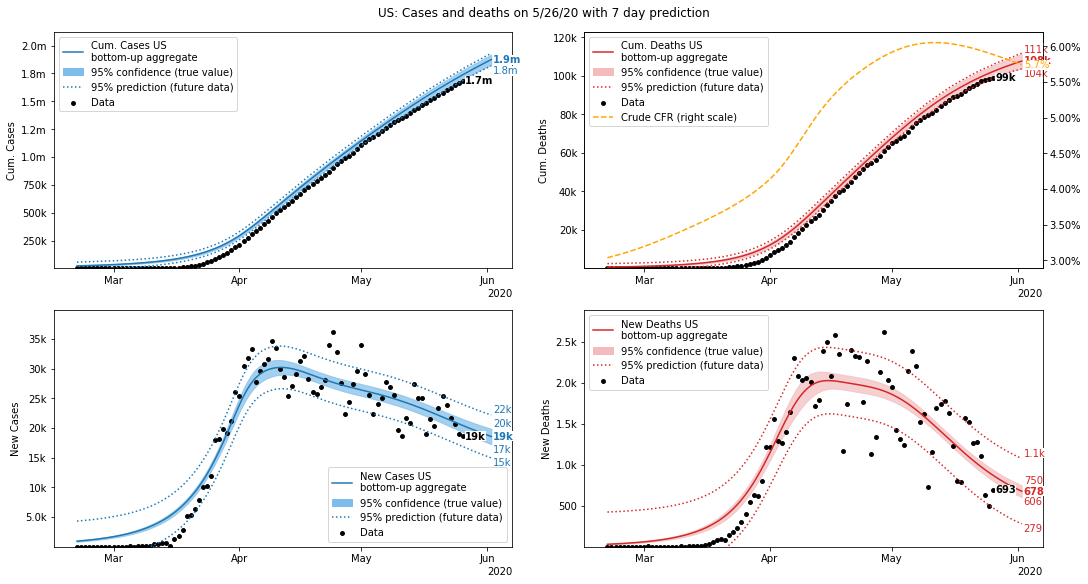

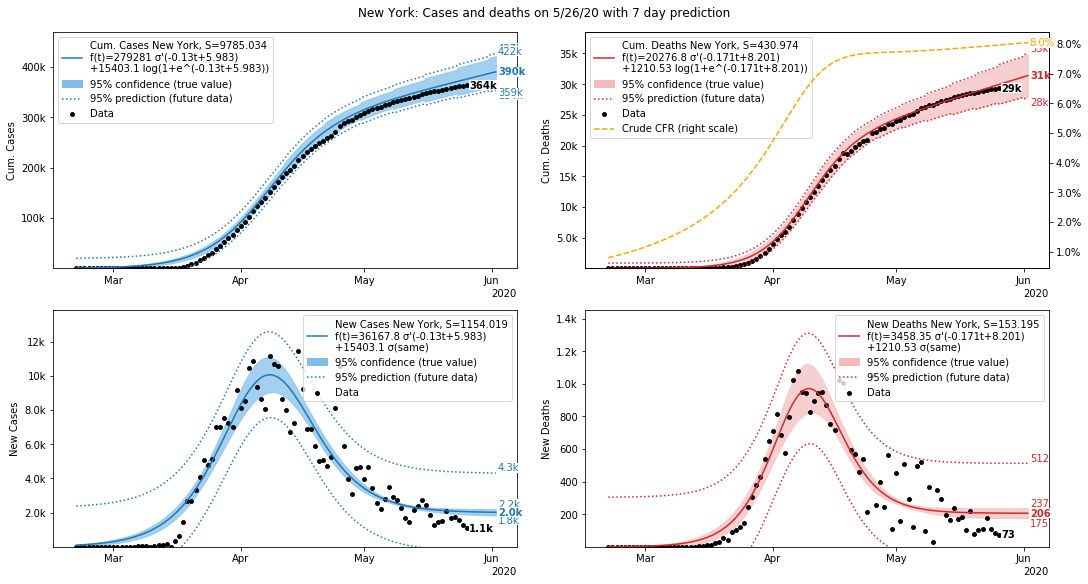

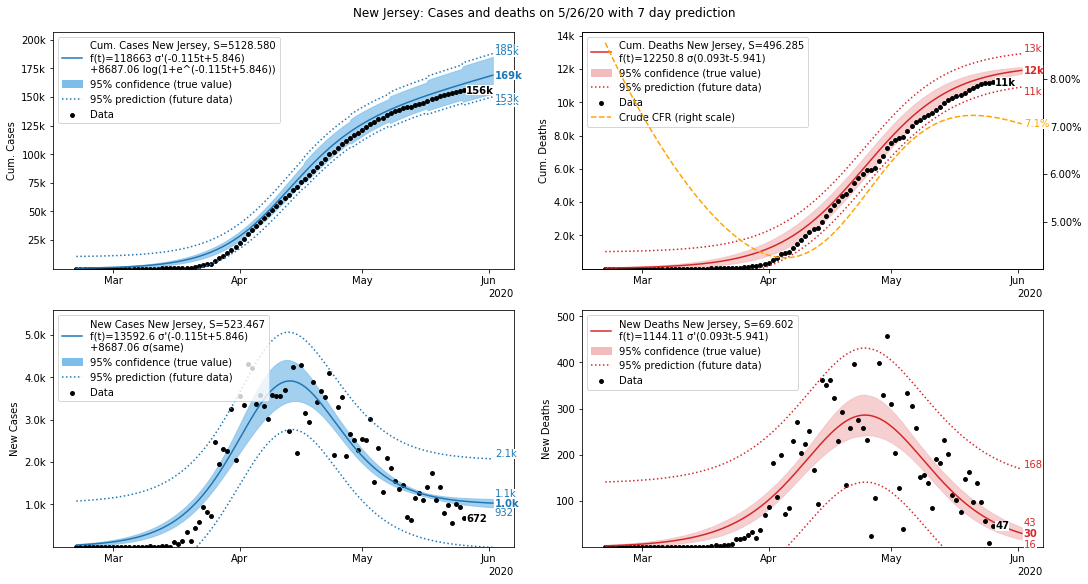

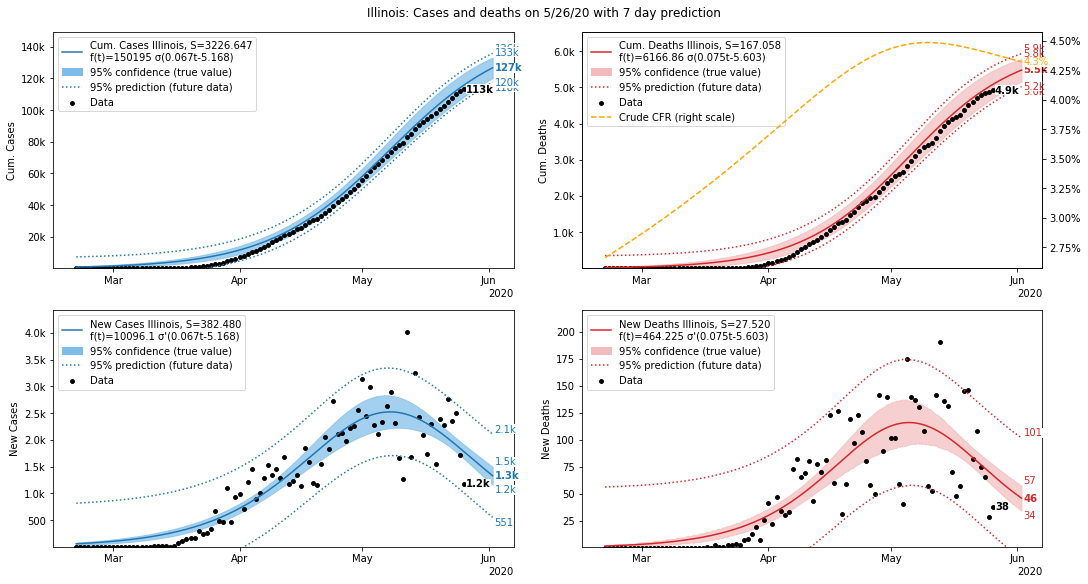

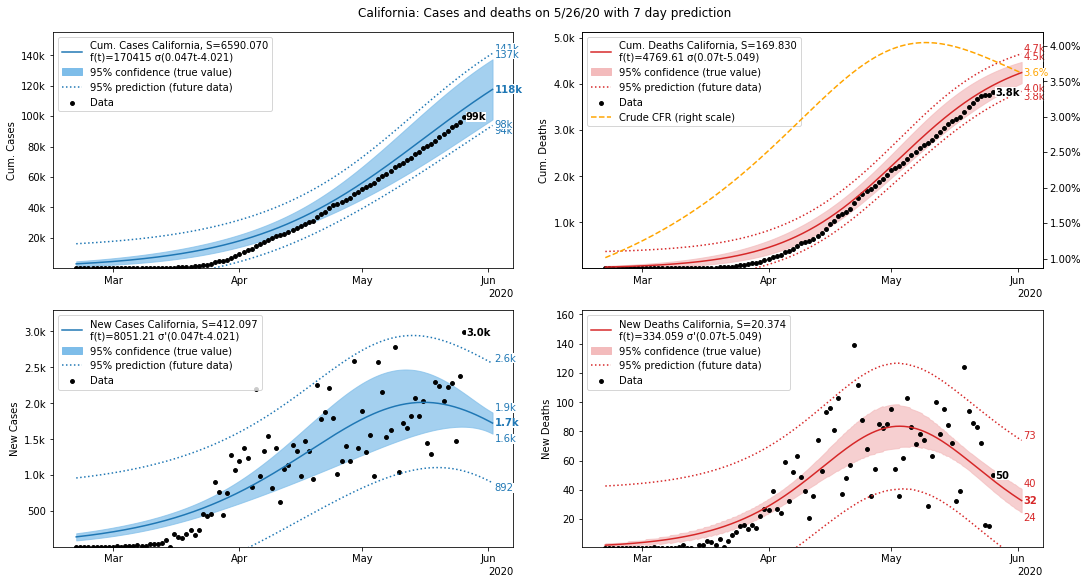

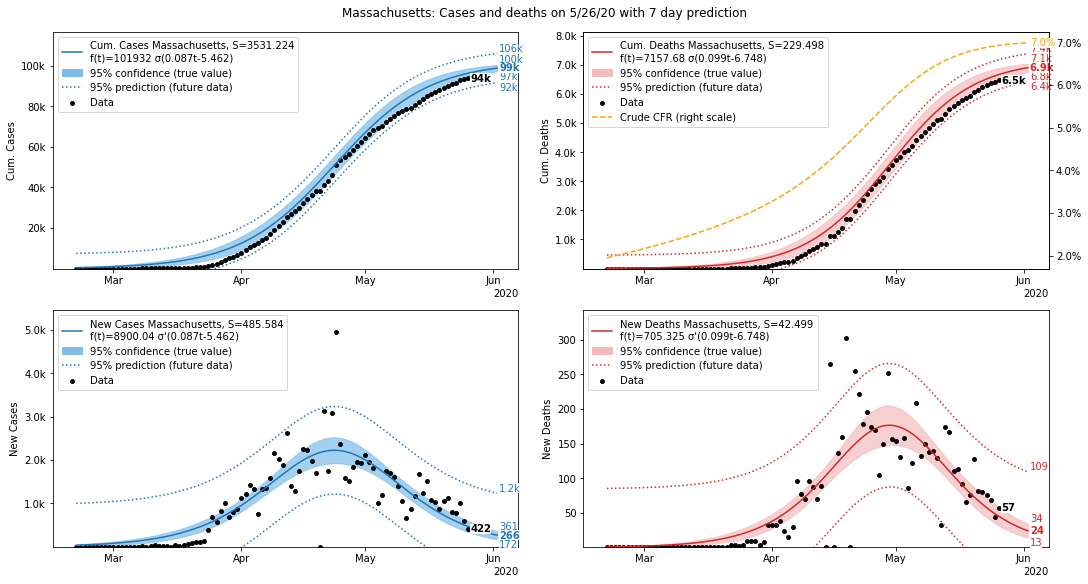

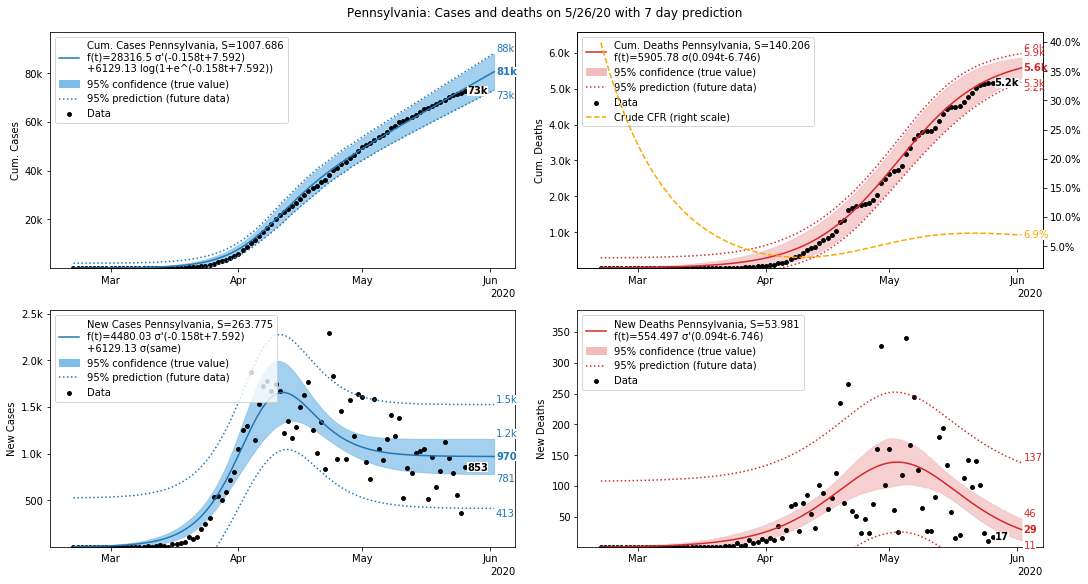

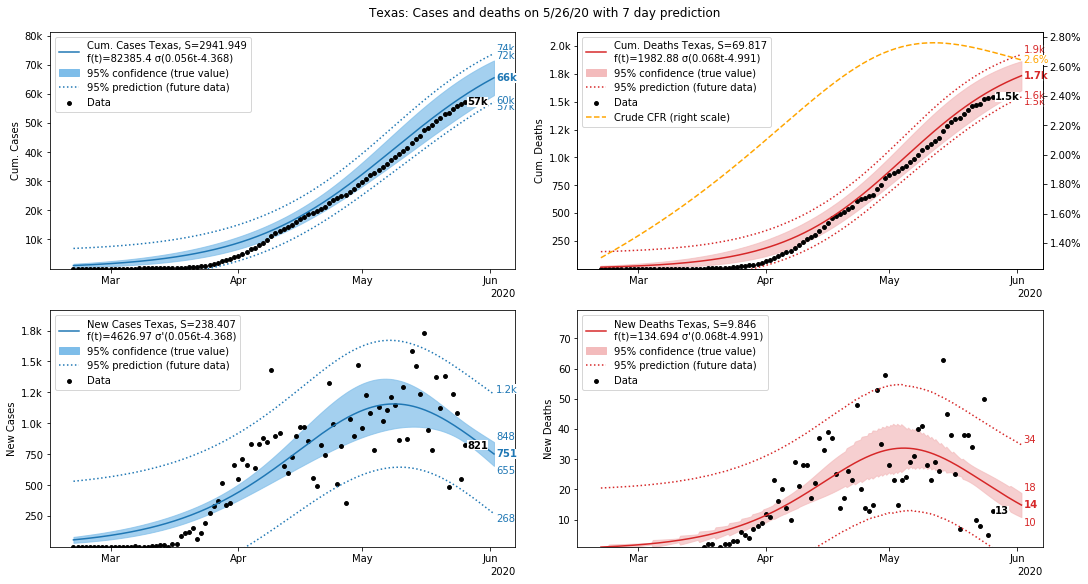

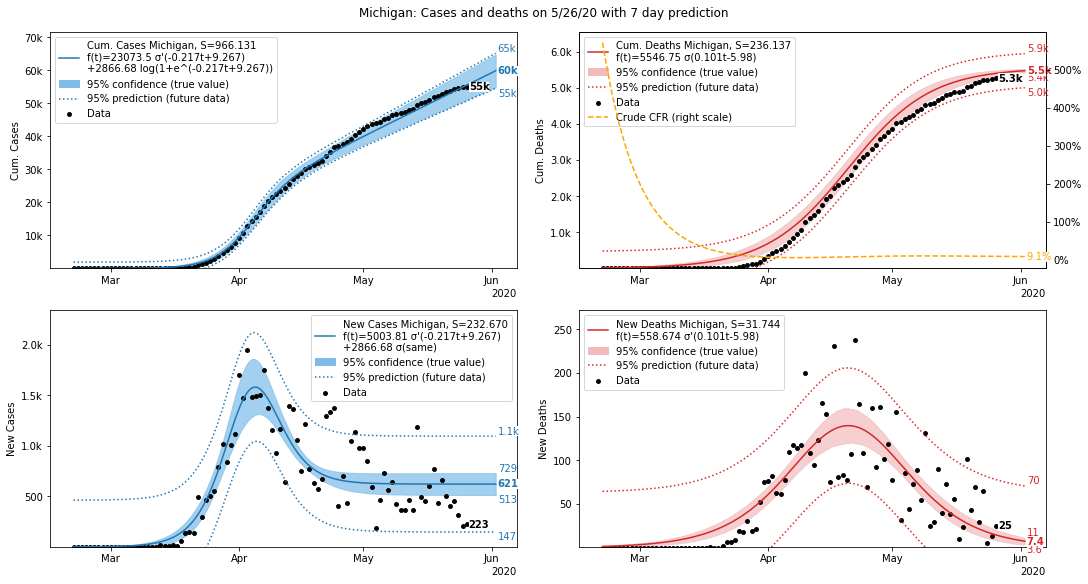

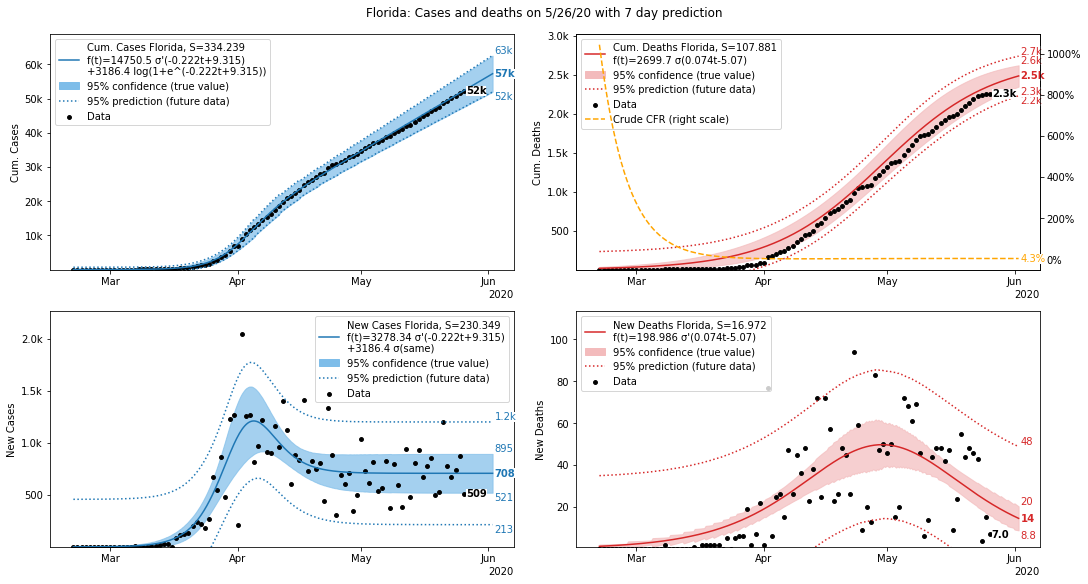

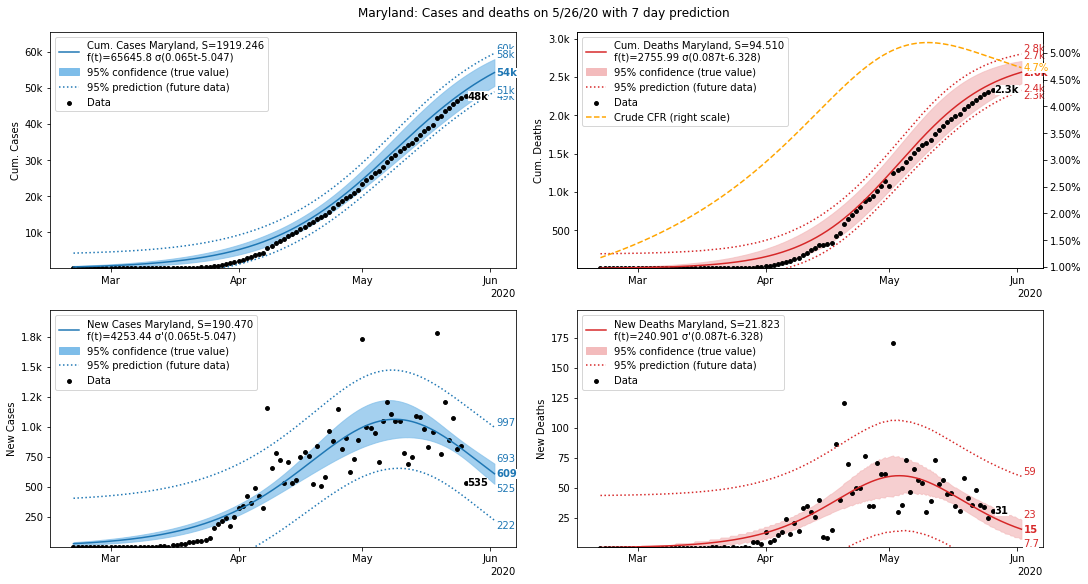

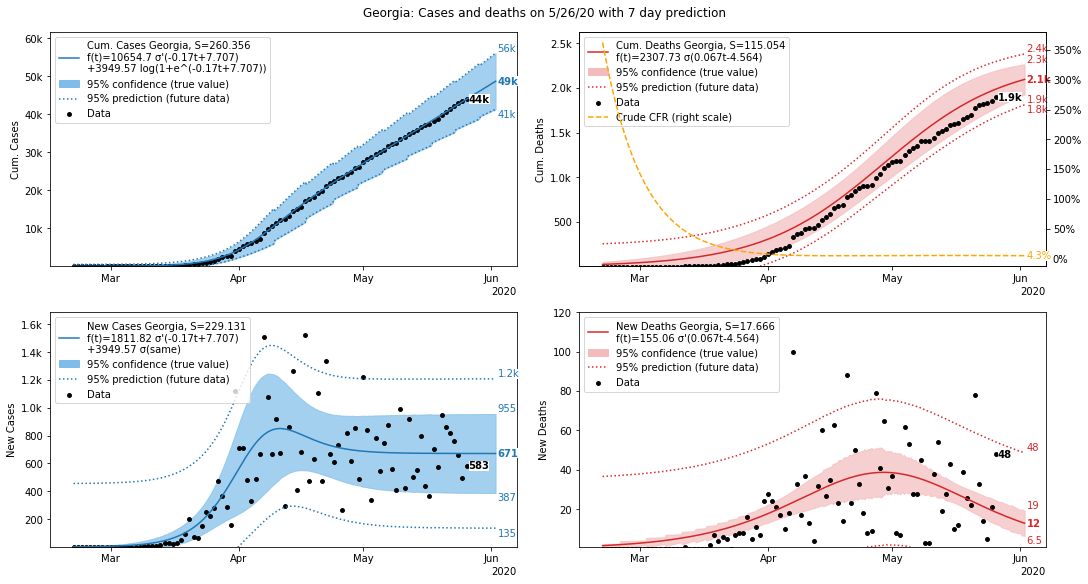

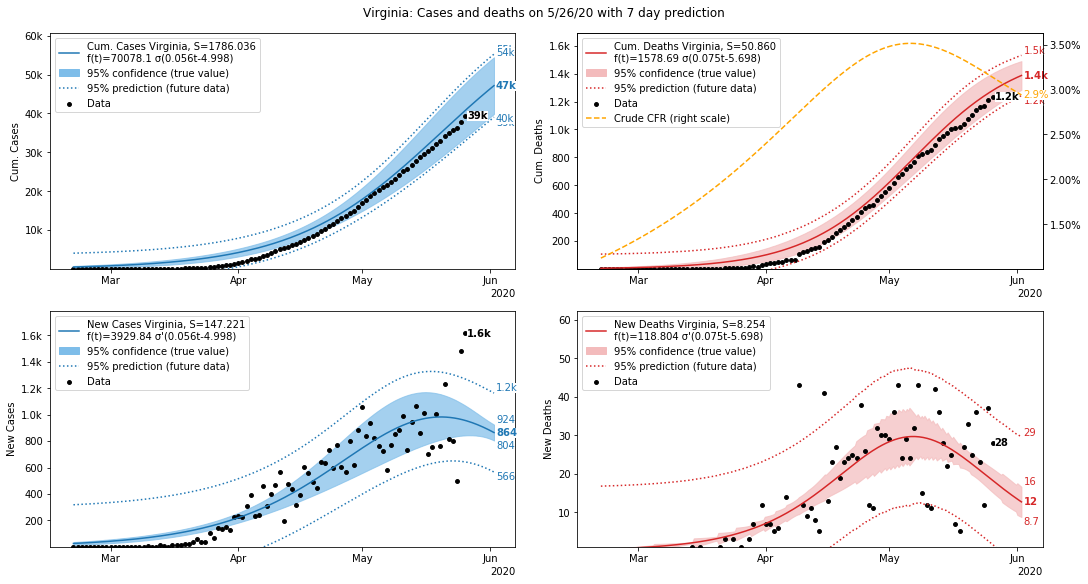

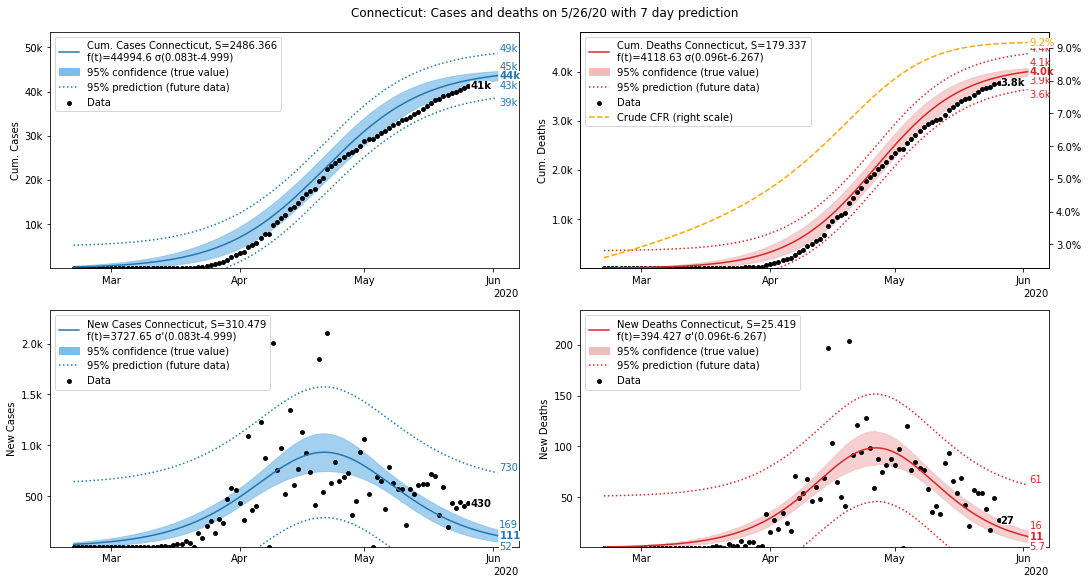

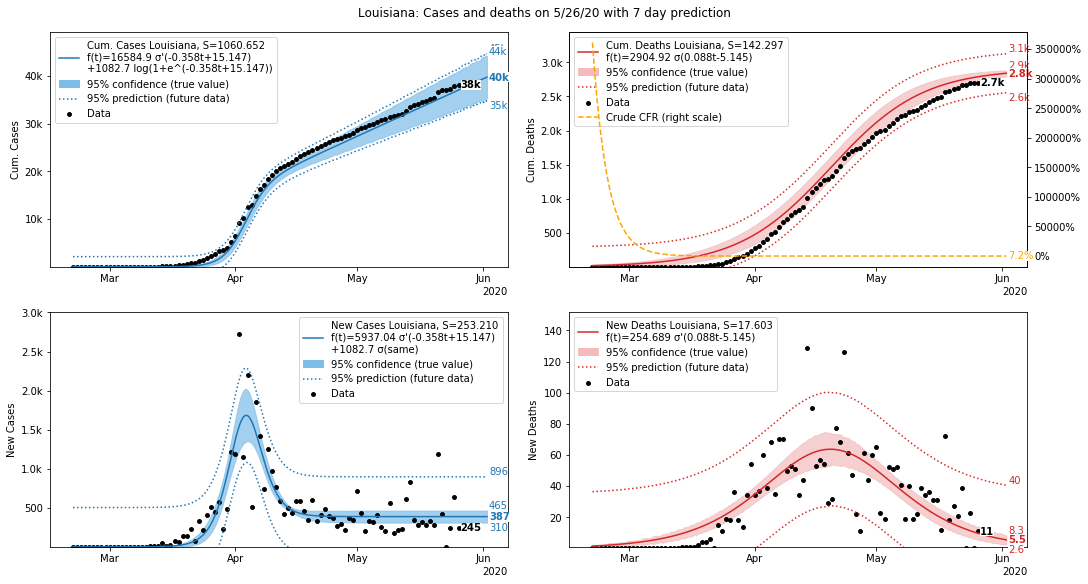

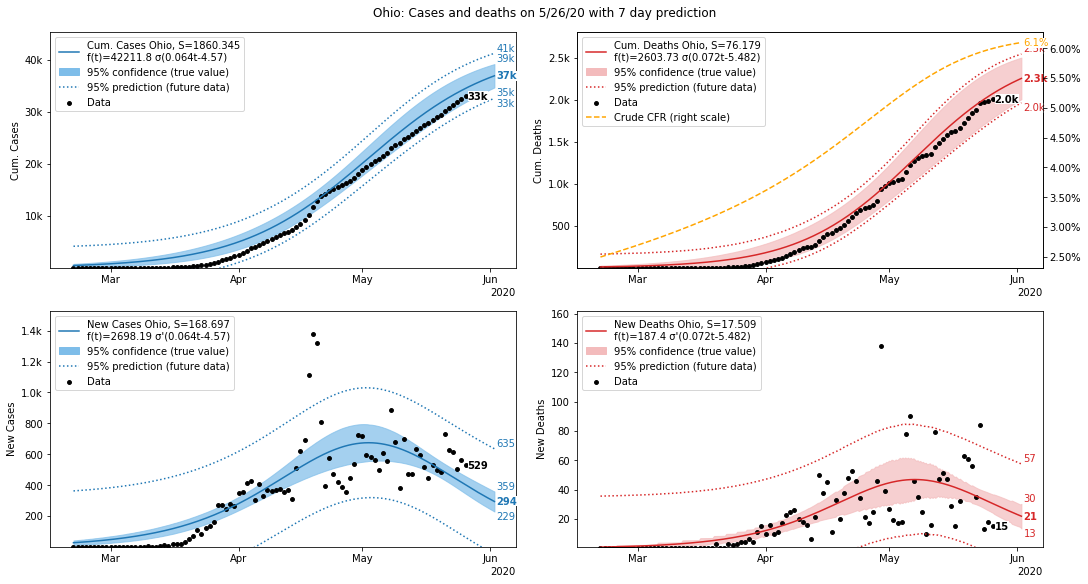

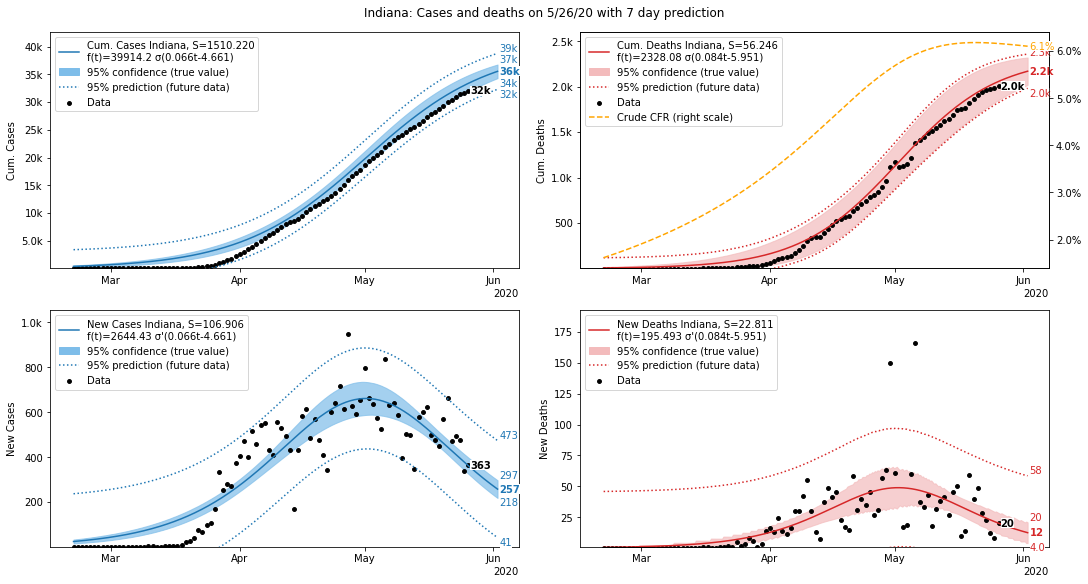

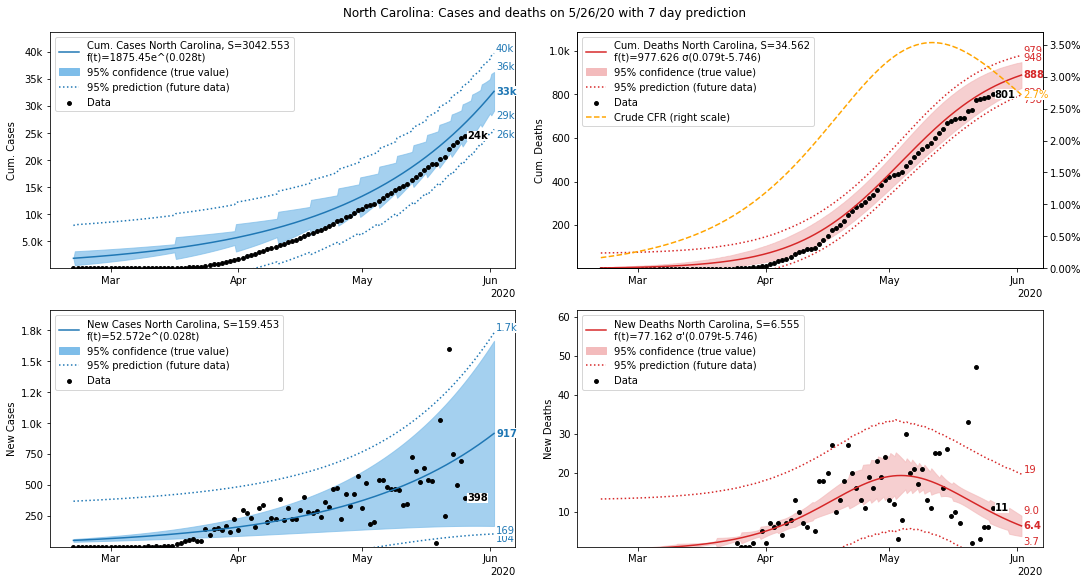

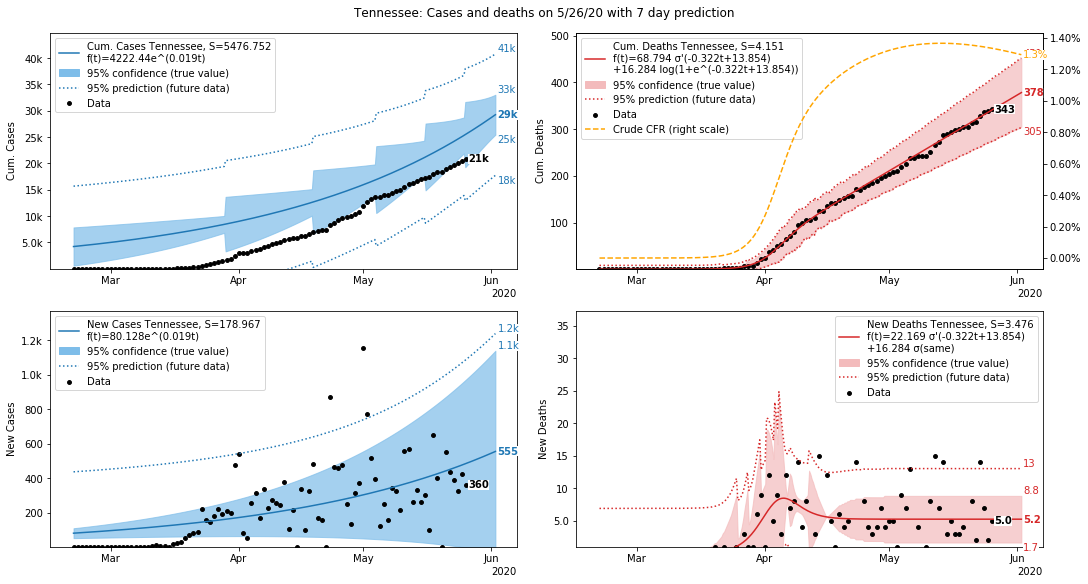

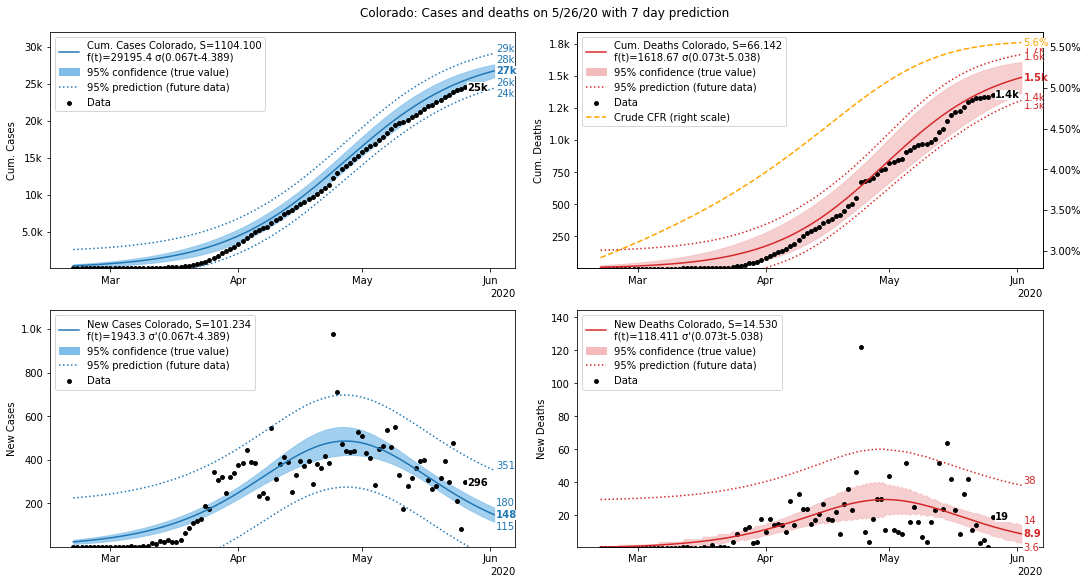

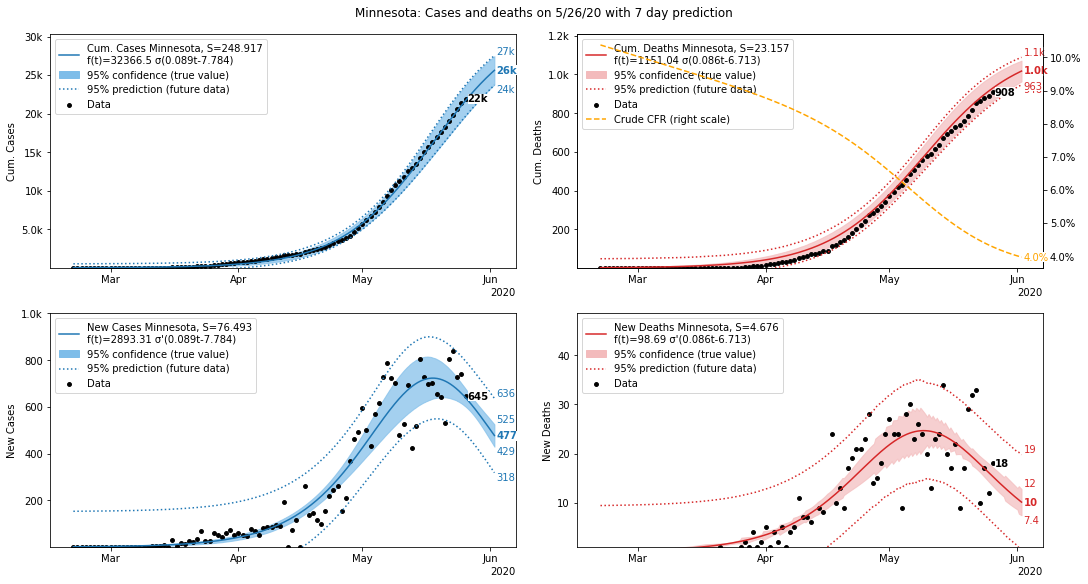

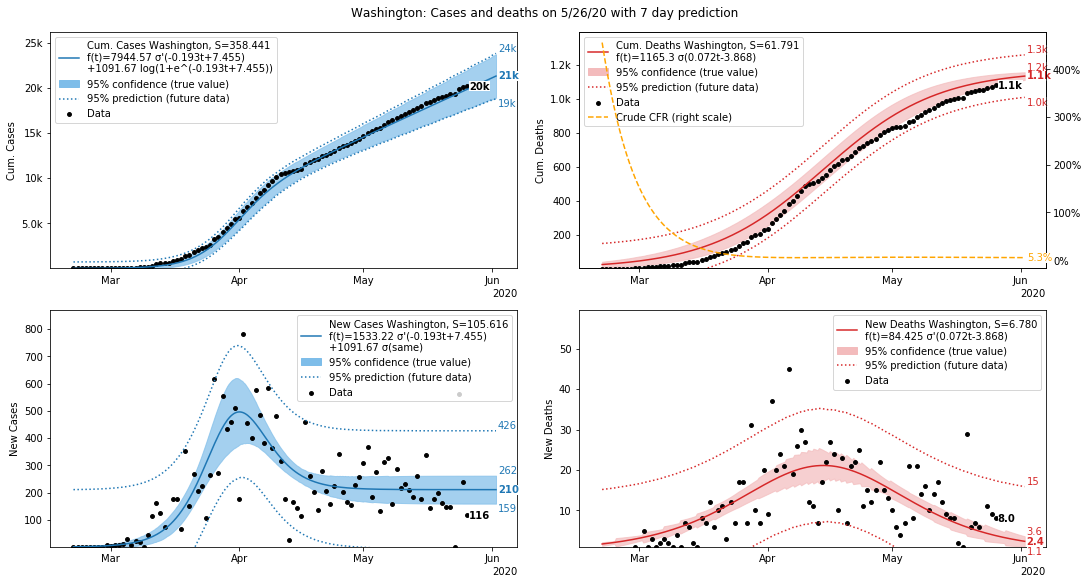

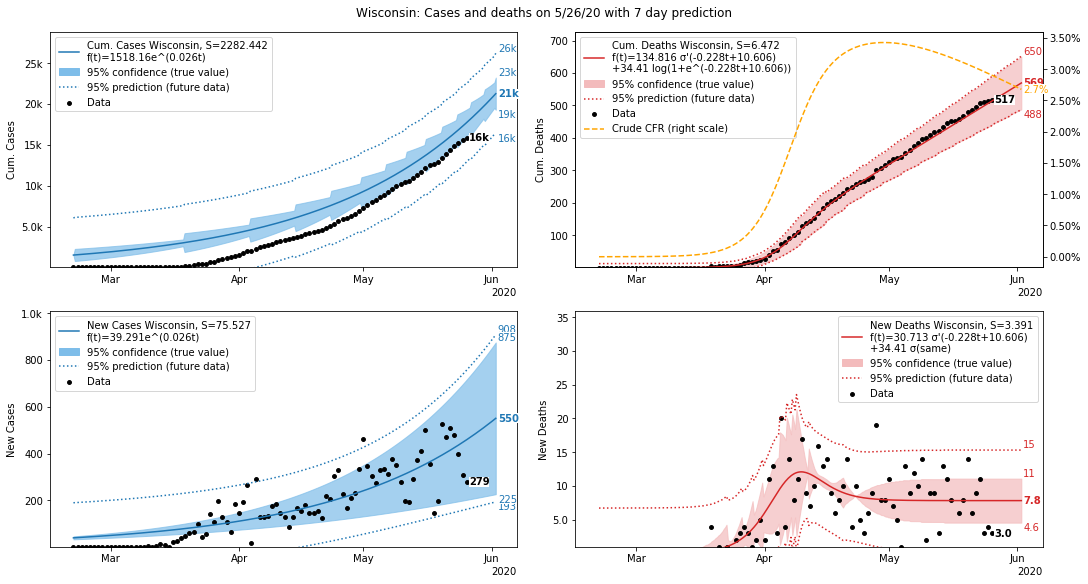

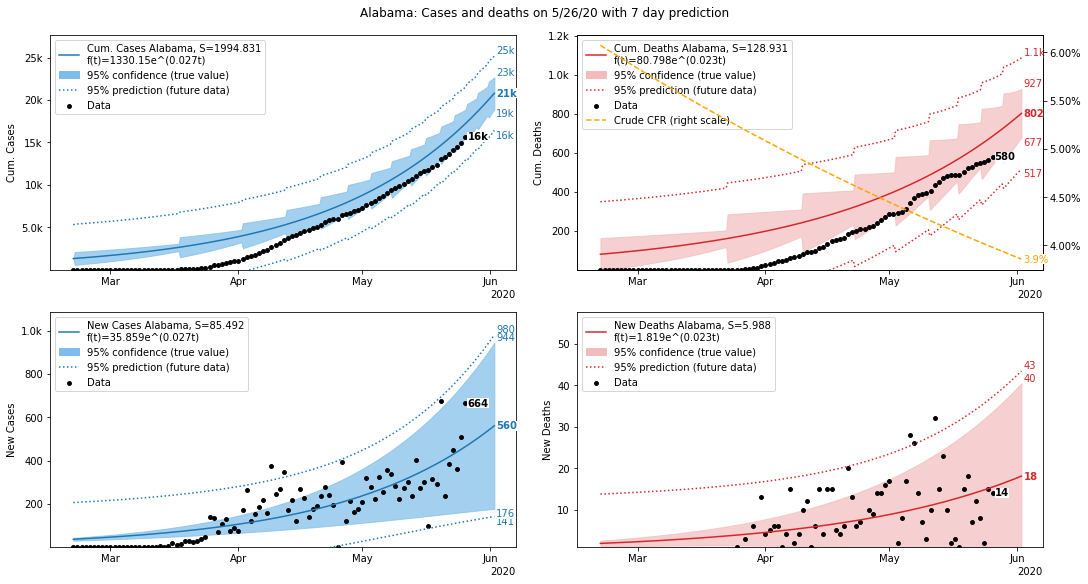

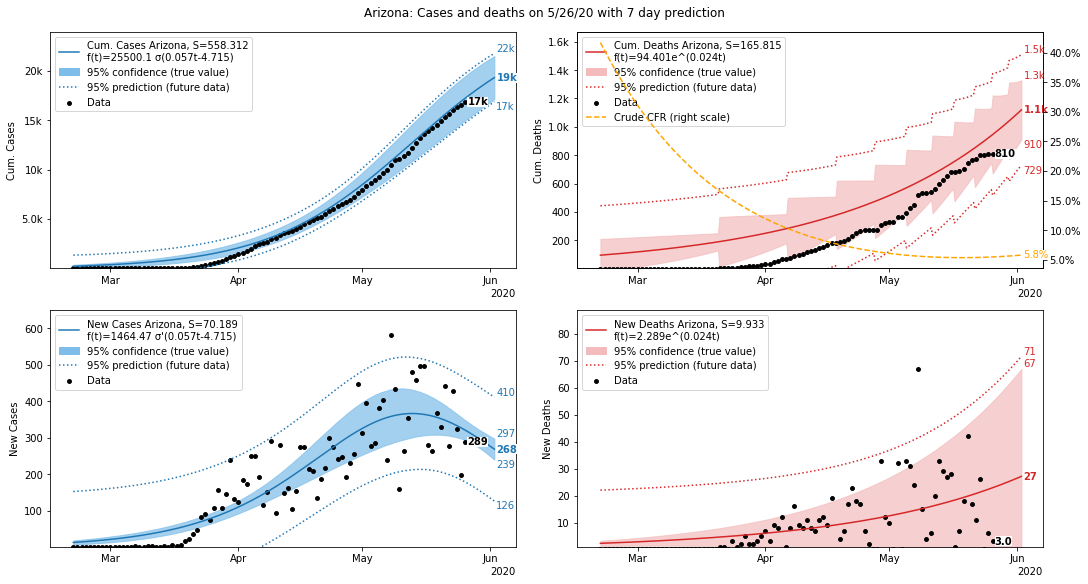

In [7]:
for countryName in cumCasesNomDF.index[:topK]: 
    fig, axs=plt.subplots(figsize=[15, 8], nrows=2, ncols=2, constrained_layout=True)
    fig.suptitle('%s: Cases and deaths on %s with %d day prediction' % (countryName, today, extDayCount))

    ccNom=None
    seriesSets=[(axs[0][0], axs[1][0], confd,  "Cases",  "tab:blue"), 
                (axs[0][1], axs[1][1], deaths, "Deaths", "tab:red")]
    for ax1, ax2, df,seriesName, seriesColor in seriesSets:
        xlabels, x, y=getData(df, countryName)
        yd= diff(y)
        n = len(yd)

        newOrCumSets=[(ax1, y,  "Cum."),
                      (ax2, yd, "New"), ]
        for ax, ys, newOrCum in newOrCumSets:
            if seriesName=="Cases":
                if newOrCum=="New":
                    f, fLabeller, popt, pcov, seor=newCasesFits.get(countryName, (None, None, [], [], 0.))
                    lpb, lcb, nom, ucb, upb=newCasesLpbDF.loc[countryName], newCasesLcbDF.loc[countryName], newCasesNomDF.loc[countryName], newCasesUcbDF.loc[countryName], newCasesUpbDF.loc[countryName]
                else:
                    f, fLabeller, popt, pcov, seor=cumCasesFits.get(countryName, (None, None, [], [], 0.))
                    lpb, lcb, nom, ucb, upb=cumCasesLpbDF.loc[countryName], cumCasesLcbDF.loc[countryName], cumCasesNomDF.loc[countryName], cumCasesUcbDF.loc[countryName], cumCasesUpbDF.loc[countryName]
                    ccNom=nom
            else:
                if newOrCum=="New":
                    f, fLabeller, popt, pcov, seor=newDeathsFits.get(countryName, (None, None, [], [], 0.))
                    lpb, lcb, nom, ucb, upb=newDeathsLpbDF.loc[countryName], newDeathsLcbDF.loc[countryName], newDeathsNomDF.loc[countryName], newDeathsUcbDF.loc[countryName], newDeathsUpbDF.loc[countryName]
                else:
                    f, fLabeller, popt, pcov, seor=cumDeathsFits.get(countryName, (None, None, [], [], 0.))
                    lpb, lcb, nom, ucb, upb=cumDeathsLpbDF.loc[countryName], cumDeathsLcbDF.loc[countryName], cumDeathsNomDF.loc[countryName], cumDeathsUcbDF.loc[countryName], cumDeathsUpbDF.loc[countryName]

            if not (f is None):
                # plot the prediction band (95% confidence)
                ax.plot(pxlabels, lpb, c=adjustLightness(seriesColor, 1.0), ls=':', label='95% prediction (future data)')
                ax.plot(pxlabels, upb, c=adjustLightness(seriesColor, 1.0), ls=':')

                # plot the confidence band (95%)
                ax.fill_between(pxlabels, lcb, ucb, color=adjustLightness(seriesColor, 1.7), alpha=0.7)
                fillBetweenLabel='95% confidence (true value)'
                fillBetweenPatch= mpatches.Patch(color=adjustLightness(seriesColor, 1.7), label=fillBetweenLabel)

                # plot the curve fit
                if countryName==totalLabel:
                    label="\nbottom-up aggregate"
                else:
                    label=(", S=%.3f\n" % seor)+ fLabeller(popt) 
                ax.plot(pxlabels, nom, c=seriesColor, label=newOrCum+' '+seriesName+' '+countryName+ label)
                
                # overlay the crude CFR curve on the cum deaths chart
                if seriesName=="Deaths" and newOrCum=="Cum.":
                    cfr=nom/ccNom
                    ax2=ax.twinx()
                    ax2.plot(pxlabels, cfr, c="orange", ls="--", label="Crude CFR (right scale)")
                    ax2.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
                    ax.plot([math.nan], [math.nan], c="orange", ls="--", label="Crude CFR (right scale)") # Fix legend

            # plot raw data
            ax.scatter(xlabels, ys, s=15, label='Data', marker='o', c='k')

            if not (f is None):
                # Label the bands in reverse order, avoiding duplicate labels
                if humanReadable(lpb[-1])!=humanReadable(nom[-1]):
                    labelLast(ax, pxlabels, lpb, c=seriesColor, va='top')
                if humanReadable(upb[-1])!=humanReadable(nom[-1]):
                    labelLast(ax, pxlabels, upb, c=seriesColor, va='bottom')
                if humanReadable(lcb[-1])!=humanReadable(nom[-1]) and humanReadable(lcb[-1])!=humanReadable(lpb[-1]):
                    labelLast(ax, pxlabels, lcb, c=seriesColor, va='top')
                if humanReadable(ucb[-1])!=humanReadable(nom[-1]) and humanReadable(ucb[-1])!=humanReadable(upb[-1]):
                    labelLast(ax, pxlabels, ucb, c=seriesColor, va='bottom')
                if seriesName=="Deaths" and newOrCum=="Cum.":
                    labelLast(ax2, pxlabels, cfr, c="orange", formatter=percentReadable)

            labelLast(ax, pxlabels, nom, c=seriesColor, weight='bold')
            labelLast(ax, xlabels, ys, c='k', weight='bold')

            # x axis formatting
            locator = mdates.AutoDateLocator(minticks=2, maxticks=4)
            formatter = mdates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)

            # y axis formatting
            ax.set_yscale("linear")
            ax.set_ylabel(newOrCum+' '+seriesName)
            ax.yaxis.set_major_formatter(hrFormatter)
            if not (f is None):
                ax.set_ylim(1, 1.1*max(max(ys), max(ucb), max(upb))+10) 
            else:
                ax.set_ylim(1, 1.1*max(ys)+10)
                
            if not (f is None):
                # fix legend order
                handles, labels = ax.get_legend_handles_labels()
                handles.append(fillBetweenPatch)
                labels.append(fillBetweenLabel)
                order = [1,3,0,2]
                if seriesName=="Deaths" and newOrCum=="Cum.":
                    order = [1,4,0,3,2]
                ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
            else:
                ax.legend()
            
    plt.show()

## Predicting new deaths from new cases

When the fitted curves for new cases and for new deaths both depart from the exponential, we can try and predict new deaths from new cases. Intuitively, this should be governed by the case fatality rate (CFR) and a time delay. As a formula, let's try and apply `predictedNewDeaths(t)=CFR x newCases(t - delay)`. Turns out, this is already a fair match, but two more refinements are necessary. Firstly, the time delay is in reality a random distribution of delays. Let's fold a normal distribution of given breadth over the newCases function to reflect this, i.e. `predictedNewDeaths(t)=CFR x (N(1.0,sigma)*newCases)(t-delay)`. Secondly, health systems don't exhibit a fixed CFR as they deliver worse outcomes when overloaded. Let's apply an overload factor to the CFR around the peak of the case curve. Results are shown below. 

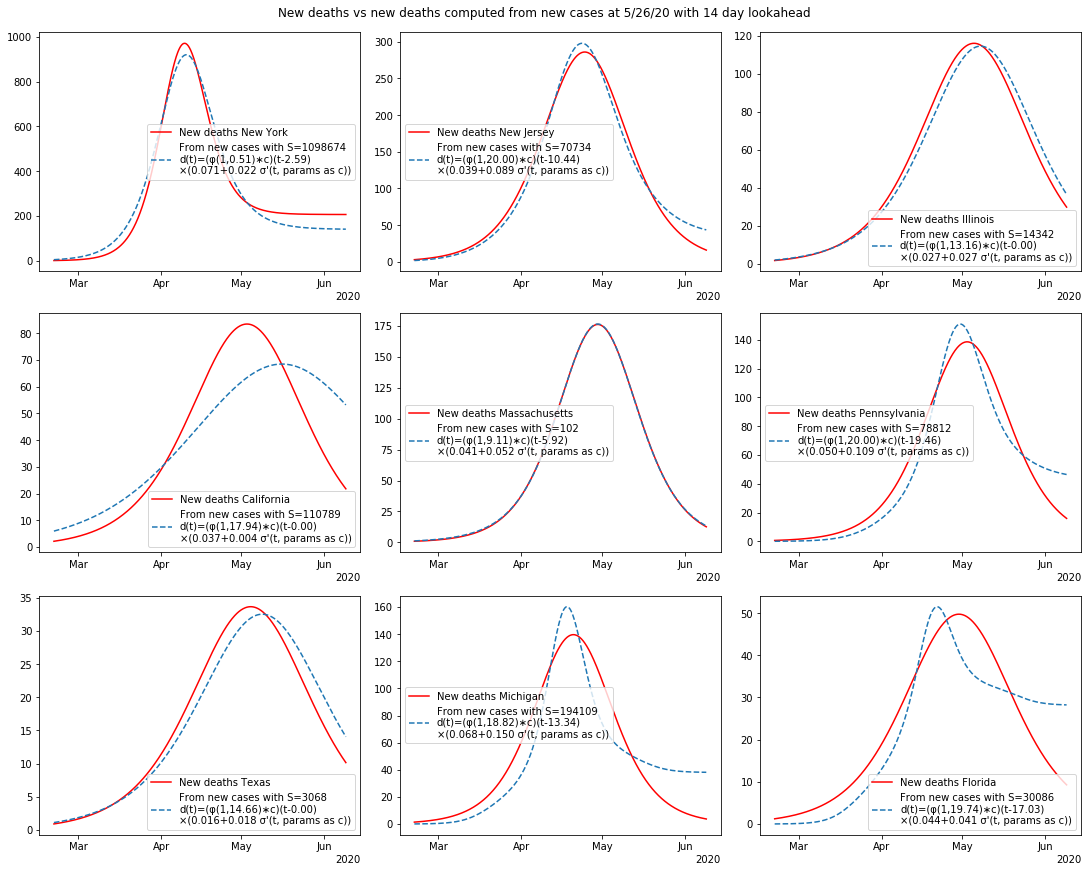

In [8]:
# Helper functions for fitting deaths from new cases
####################################################

# Gaussian normal distribution
def gaussian(x, sigma=1.0, mu=1.0):
    return math.exp(-((x-mu)**2)/(2*(sigma**2)))/(math.sqrt(2.0*math.pi)*sigma)

# Quantized gaussian for folding on an integer grid
def gaussianQuant(x, sigma=1.0, mu=0.0):
    return 0.5*(gaussian(x-0.5, sigma, mu)+gaussian(x+0.5, sigma, mu))



inferredNames, inferredCFRs, inferredDelays=[], [], []
inferredCFRLookup={}
countryNamesForMatching=[]
for countryName in cumCasesNomDF.index[1:]: 
    cf, cfLabeller, cpopt, cpcov, cr2=newCasesFits.get(countryName, (None, None, [], [], 0.0))
    df, dfLabeller, dpopt, dpcov, dr2=newDeathsFits.get(countryName, (None, None, [], [], 0.0))
    if cf is None or df is None or cf==fitExpDerivative or df==fitExpDerivative:
        continue
    if deaths.loc[countryName, confd.columns[-1]]<100:
        continue
    countryNamesForMatching.append(countryName)

countryNamesForCharts=countryNamesForMatching[:9]
extDayCount=14
fig, axs=plt.subplots(figsize=[15, 4*int((len(countryNamesForCharts)+2)/3)], nrows=int((len(countryNamesForCharts)+2)/3), ncols=3, constrained_layout=True)
fig.suptitle('New deaths vs new deaths computed from new cases at %s with %d day lookahead' % (today, extDayCount))
for i, countryName in enumerate(countryNamesForMatching): 
    cf, cfLabeller, cpopt, cpcov, cr2=newCasesFits.get(countryName, (None, None, [], [], 0.0))
    df, dfLabeller, dpopt, dpcov, dr2=newDeathsFits.get(countryName, (None, None, [], [], 0.0))
    
    xlabels, x, y=getData(confd, countryName)
    yd= diff(y)
    n = len(yd)   

    px       = np.linspace(x[0], x[-1]+extDayCount, 5*(len(x)+extDayCount)) # resample to make curves smoother
    pxlabels = [datetime.datetime.combine(xlabels[0],datetime.time(0,0,0))+datetime.timedelta(days=(d-x[0])) for d in px]
    dpy      = df(px, *(dpopt))

    # Fitting function for deaths, based on true CFR and time delay
    def fitdf(t, cfr, delay):
        return cfr*cf(t-delay, *(cpopt))

    # Fitting function for deaths, based on true CFR, time delay and gaussian delay of outcomes
    def fitdfg(t, cfr, delay, sigma):
        sum, i=0, 0
        while True:
            gq=gaussianQuant(i, sigma)
            if gq<0.005:
                break
            l=gq*fitdf(t-i, cfr, delay)
            r=gq*fitdf(t+i, cfr, delay) if i!=0 else 0
            sum+=l+r
            i+=1
        return sum

    # Fitting function for deaths, based on true CFR, time delay and gaussian delay of outcomes, and overload
    def fitdfgo(t, cfr, delay, sigma, cfrOverload):
        sum, i=0, 0
        weight=fitSigDerivative(t-delay, 4.0/cpopt[1], cpopt[1], cpopt[2])
        weightedCFR=cfr+weight*cfrOverload
        while True:
            gq=gaussianQuant(i, sigma)
            if gq<0.005:
                break
            l=gq*fitdf(t-i, weightedCFR, delay)
            r=gq*fitdf(t+i, weightedCFR, delay) if i!=0 else 0
            sum+=l+r
            i+=1
        return sum

    
    try:
        popt, pcov =curve_fit(fitdfgo, px, dpy, [0.03, 10, 2.0, 0.07], 
                              bounds=([0, 0, 0.3, 0], [0.2, 40, 20, 0.3]) )
        sqdiff     = sum((dpy-fitdfgo(px,*(popt)))**2)
        
    except (RuntimeError) as e:
        print(countryName, e)
        ax.legend()
        continue
    
    inferredNames.append(countryName)
    inferredCFRs.append(popt[0])
    inferredDelays.append(popt[1])
    inferredCFRLookup[countryName]=popt[0]

    # Plot data
    if i<len(countryNamesForCharts):
        ax=axs[int(i/3)][int(i%3)]
        locator = mdates.AutoDateLocator(minticks=2, maxticks=4)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)    

        ax.plot(pxlabels, dpy, label="New deaths %s" % countryName, c="r")

        dpyFromCases=fitdfgo(px, *(popt))
        ax.plot(pxlabels, dpyFromCases, label="From new cases with S=%.f\nd(t)=(\u03c6(1,%.2f)\u2217c)(t%+.2f)\n\u00d7(%.3f+%.3f \u03c3'(t, params as c))" % (sqdiff, 
                                                                 popt[2], -popt[1], popt[0], popt[3]), c="tab:blue", ls="--")
        #ax2=ax.twinx()
        #helperys=fitSigDerivative(px-popt[1], 4.0/cpopt[1], cpopt[1], cpopt[2])
        #ax2.plot(pxlabels, helperys, label="Weight y" , c="orange", ls="--")
        ax.legend()
            
plt.show()

For the states where data is available, inferred CFRs and delays range widely. Part of this can likely be attributed to a difference in testing intensity. Part of it may also be attributable to locally overwhelmed health systems, and/or general differences in health system capacity relative to population size.

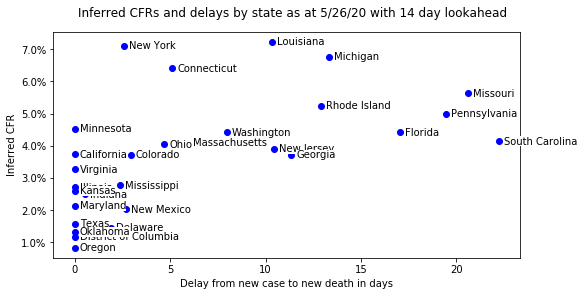

In [9]:
fig, axs=plt.subplots(figsize=[8, 4], nrows=1, ncols=1, constrained_layout=True)
fig.suptitle('Inferred CFRs and delays by state as at %s with %d day lookahead' % (today, extDayCount))
axs.plot(inferredDelays, inferredCFRs, "bo")
axs.set_xlabel("Delay from new case to new death in days")
axs.set_ylabel("Inferred CFR")
axs.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))

for name, delay, cfr in zip(inferredNames, inferredDelays, inferredCFRs):
    axs.annotate(name, (delay,cfr), (5,0), textcoords='offset pixels', ha='left', va="center", bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

plt.show()


## Comparing Inferred CFRs with Crude CFRs

Matching curves for new deaths and new cases, the pattern `new_deaths(t)=inferred_cfr * new_cases(t - delay)` generally seems to hold. The two parameters are an inferred case fatality rate `inferred_cfr`, and the average time between reporting of a case and the reporting of a fatal outcome, `delay`. Let´s see how the inferred CFR relates to crude CFR, defined as number of cumulative deaths over cumulative cases.

As you can see for selected states below, crude CFRs vary strongly over time. They first dip from a high level in the eary stages of an epidemic. Then they recover almost symmetrically, and converge on a final value. However, they can start both above and below the inferred CFRs. They can also end both above and below. Hence, crude CFR remains a poor indicator. 

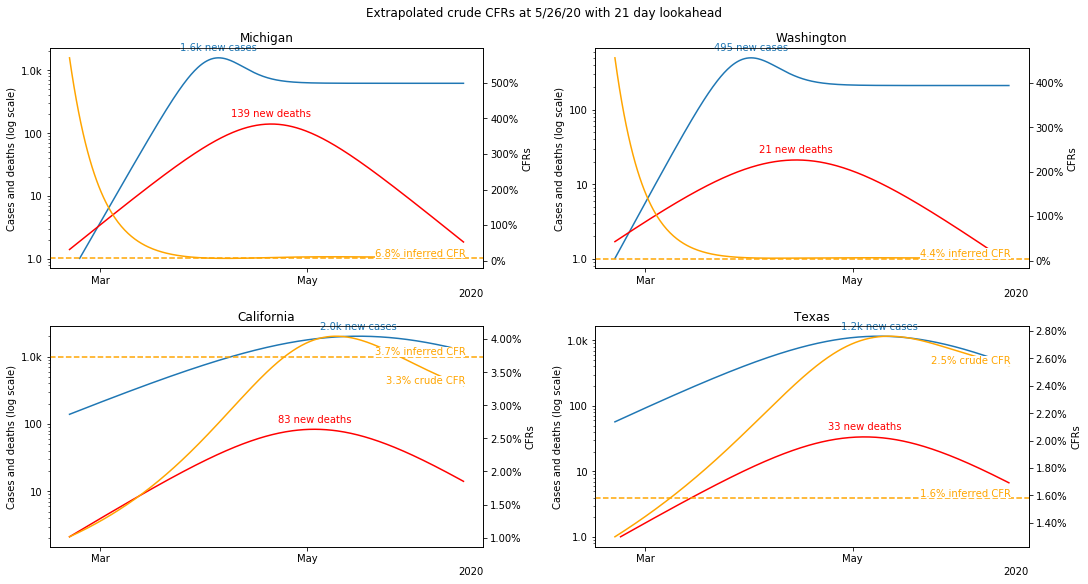

In [10]:
# Use extended prediction intervals
extDayCount=21
px       = np.linspace(0, len(confd.columns)-1+extDayCount, 3*(len(confd.columns)+extDayCount)) # resample to make curves smoother
firstDay=datetime.datetime.strptime(confd.columns[0],"%m/%d/%y").date()
pxlabels = [datetime.datetime.combine(firstDay,datetime.time(0,0,0))+datetime.timedelta(days=(d)) for d in px]

fig, axs=plt.subplots(figsize=[15, 8], nrows=2, ncols=2, constrained_layout=True)
fig.suptitle('Extrapolated crude CFRs at %s with %d day lookahead' % (today, extDayCount))

for i, countryName in enumerate(['Michigan', 'Washington', 'California', 'Texas']):
    ax=axs[int(i/2)][int(i%2)]
    # Predict for each country    
    def pred(f, fLabeller, popt, pcov, seor):
        return [x if x>=1.0 else math.nan for x in f(px, *popt)]
    cn=pred(*newCasesFits[countryName])
    cc=pred(*cumCasesFits[countryName])
    dn=pred(*newDeathsFits[countryName])
    dc=pred(*cumDeathsFits[countryName])

    # Calculate CFRs
    cfr=[d/c if d is not math.nan and c is not math.nan else math.nan for d,c in zip(dc, cc)]
    inferredCFR=inferredCFRLookup[countryName]

    # Prepare plot area
    ax.set_title(countryName)
    ax2=ax.twinx()
    ax2.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))

    # Plot cases and deaths on left scale
    line1=ax.plot(pxlabels, cn, color='tab:blue', label='New cases')
    line2=ax.plot(pxlabels, dn, color='red', label='New deaths')
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(hrFormatter)
    ax.set_ylabel('Cases and deaths (log scale)')

    # Plot CFRs on right scale
    line3=ax2.plot(pxlabels, cfr, color='orange', label="Crude CFR")
    locator = mdates.AutoDateLocator(minticks=2, maxticks=4)
    formatter = mdates.ConciseDateFormatter(locator)
    ax2.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_formatter(formatter)    
    ax2.set_ylabel('CFRs')
    line4=ax2.axhline(y=inferredCFR, color='orange', ls="--", label="Inferred CFR")
    
    # Label the curves
    labelMax (ax,  pxlabels, cn,  c=line1[0].get_color(), ha='center', formatter=lambda x: "%s new cases" % humanReadable(x))
    labelMax (ax,  pxlabels, dn,  c=line2[0].get_color(), ha='center', formatter=lambda x: "%s new deaths" %  humanReadable(x))
    labelLast(ax2, pxlabels, cfr, c=line3[0].get_color(), ha='right',  va='bottom', formatter=lambda x: "%.1f%% crude CFR" % (100*x))
    labelLast(ax2, pxlabels[-1:], [inferredCFR], c=line3[0].get_color(), ha='right',  va='bottom', formatter=lambda x: "%.1f%% inferred CFR" % (100*x))

plt.show()


## A look at weekday patterns

I have suspected for a while that there might be a weekday pattern to the data we see. To test this hypothesis, let's calculate the percentage growth of new cases for each day, subtract the average for the prior week from this, and bin the growth rates by day of week. 

Here is what we get for the ten most impacted states: New York, California and Illinois appear to display the largest weekday differences.


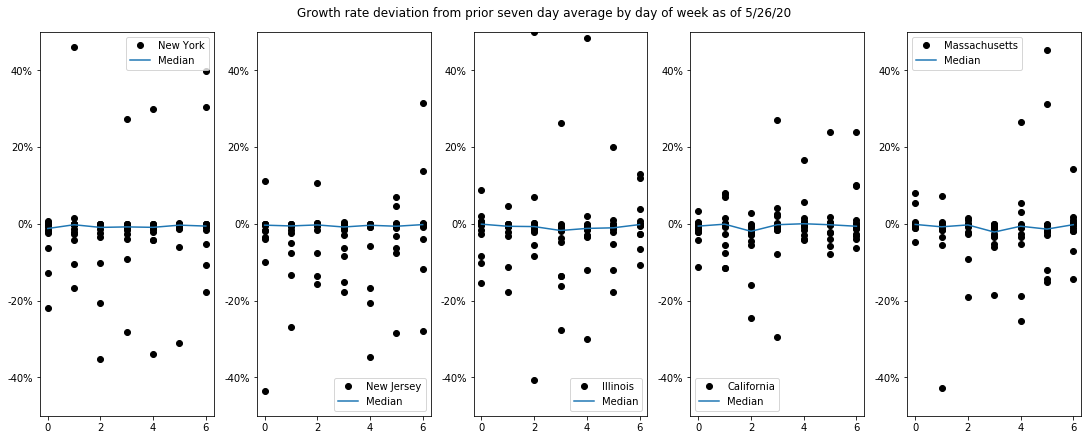

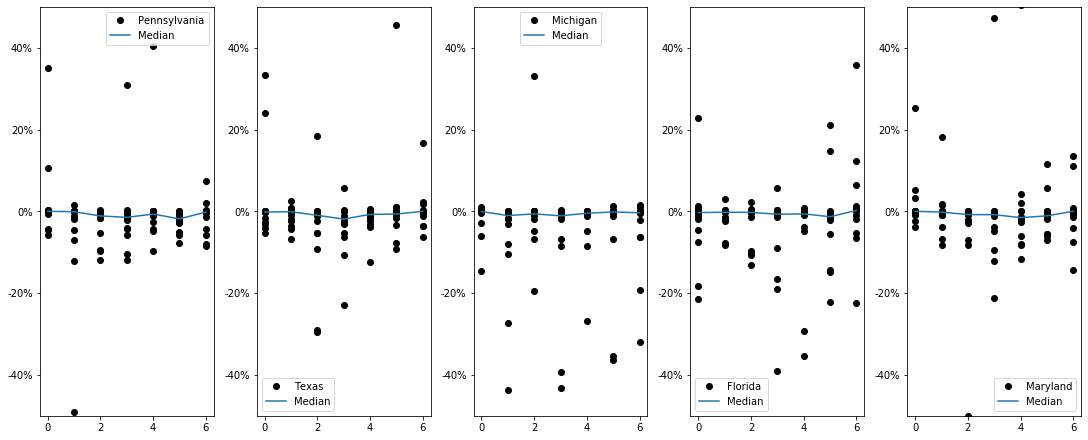

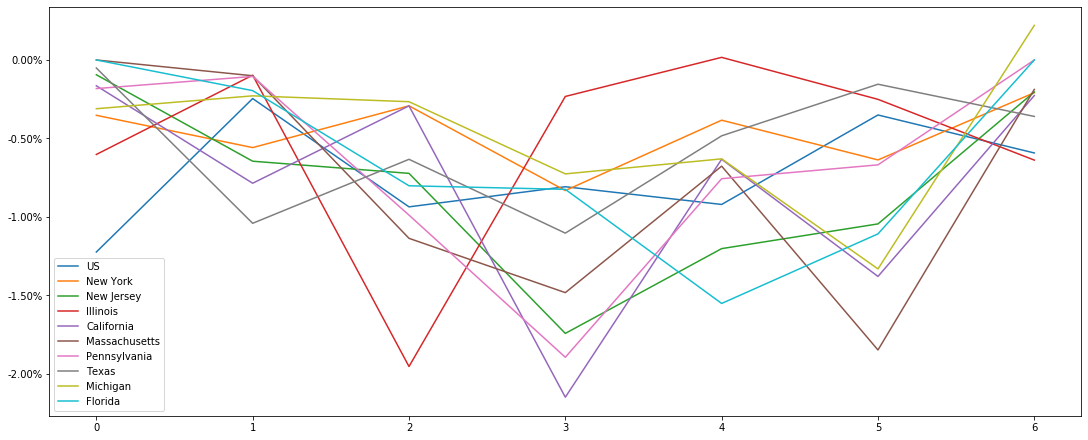

In [11]:
# Calculate daily difference in growth rate from prior seven days average
confdDeltaPercNorm=confdDeltaPerc.copy()
for i in range(len(confdDeltaPercNorm.columns)):
    lower=max(0, i-7)
    if i>0:
        mean=confdDeltaPerc.iloc[:, lower:i].mean(axis=1)
        confdDeltaPercNorm.iloc[:,i]=confdDeltaPerc.iloc[:,i]-mean
    else:
        confdDeltaPercNorm.iloc[:,i]=confdDeltaPerc.iloc[:,i]

# For each country, summarize by day of week and plot
labels=[x % 7 for x in range(len(confdDeltaPerc.columns))]
countryMedians=[]

# Group in rows of five countries
for ctygroup in range(1, len(validCountriesForCharts[:10]), 5):
    fig, axs=plt.subplots(figsize=[15, 6], nrows=1, ncols=5, constrained_layout=True)
    if ctygroup==1:
        fig.suptitle('Growth rate deviation from prior seven day average by day of week as of %s' % (today))

    for idx,cty in enumerate(validCountriesForCharts[ctygroup:ctygroup+5]):
        # Plot by country
        ax=axs[idx]
        countryName=cty['Name']
        ys=confdDeltaPercNorm.loc[countryName]
        ax.plot(labels, ys, marker='o', ls='', c='k', label=countryName)
        
        vals=[[], [], [], [], [], [], []]
        medians=[0]*7
        for l, y in zip(labels, ys):
                vals[l].append(y)
        for i in range(len(vals)):
            medians[i]=np.median(vals[i])
        countryMedians.append(medians)
        ax.plot(labels[:7], medians, ls='-', c='tab:blue', label="Median")

        #for i in range(7):
        #    print(labels[i], medians[i])
        #    ax.annotate(medians[i], (labels[i],medians[i]), (2,0), textcoords='offset pixels', ha='left', va='center', c=c, weight='normal', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

        ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
        ax.set_ylim(-0.5,0.5)
        ax.legend()

    plt.show()

# Plot summary
fig, ax=plt.subplots(figsize=[15, 6], nrows=1, ncols=1, constrained_layout=True)
for cty, med in zip(validCountriesForCharts, countryMedians):
    # Plot by country
    countryName=cty['Name']
    ax.plot(labels[:7], med, ls='-', label=countryName)

ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.legend()
plt.show()


Return to [daily series overview](https://mlnoga.github.io/covid19-analysis/). Data source: [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19). For questions and comments, please reach out to me on [LinkedIn](https://www.linkedin.com/in/mlnoga/) or [Twitter](https://twitter.com/mlnoga).